<a href="https://colab.research.google.com/github/Mefoolyhi/PHA-Biodegradation/blob/main/Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

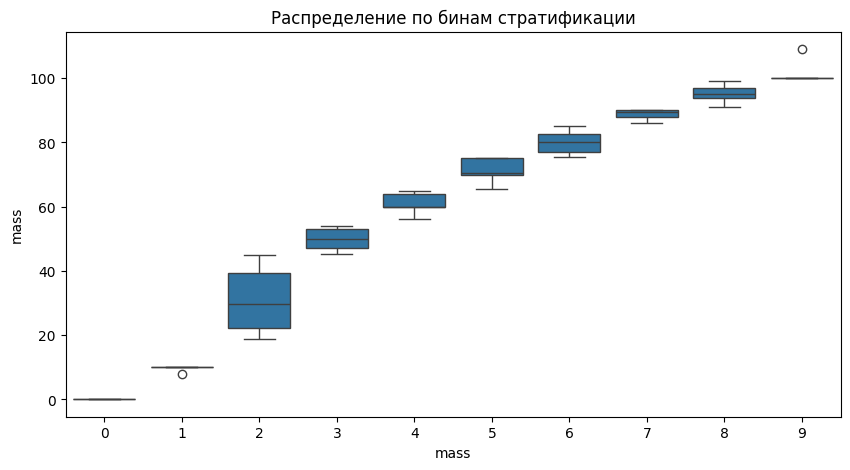

Original y: [100.    95.    90.    85.    80.    75.    70.    65.    60.   100.
  98.    96.    94.    92.    90.    88.    86.    84.    90.    80.
  70.    60.    95.    85.    75.    65.    98.    90.    80.    70.
  95.    85.    75.    65.    90.    80.    70.    60.    95.    85.
  75.    65.    80.    60.    40.    20.    75.    50.    30.    10.
 100.    97.    94.    91.    88.    85.    82.    79.    76.   100.
  99.    98.    97.    96.    95.    94.    93.    92.    77.5   77.5
  20.    33.    10.    20.    40.    37.5   60.    60.    25.   100.
 100.    75.    45.   100.   100.   100.   100.    63.    53.    27.
  61.    53.    29.    67.    54.    29.    92.    88.    86.    78.
  66.    70.    64.    84.   109.    96.    77.    93.    70.    45.
  39.    88.    94.    74.    80.    75.    37.    40.    29.    76.
  88.    47.    62.    56.    22.    21.    19.    50.    64.    34.
  40.    40.   100.   100.   100.   100.   100.   100.    80.    76.
  75.    95.    75.  

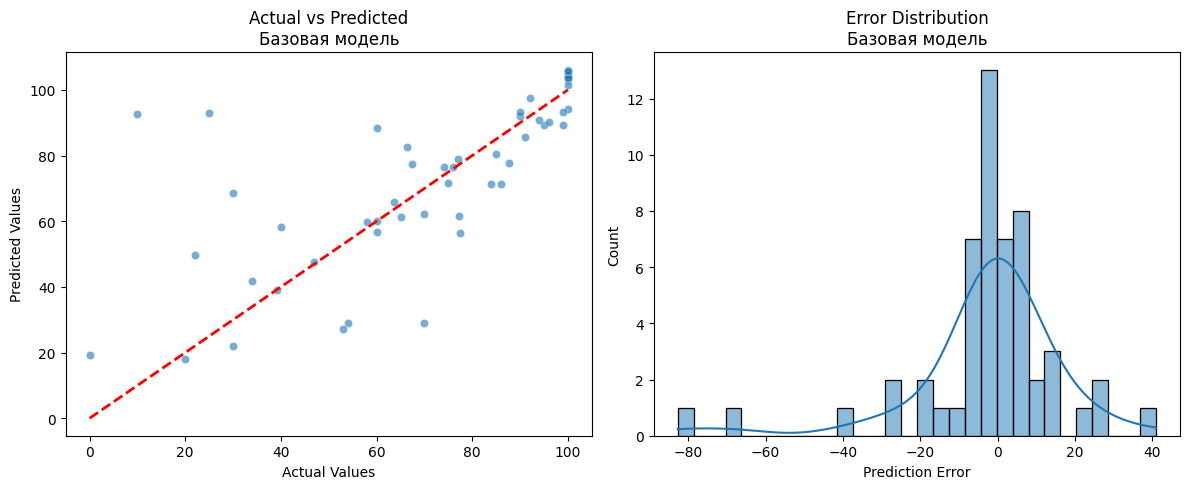

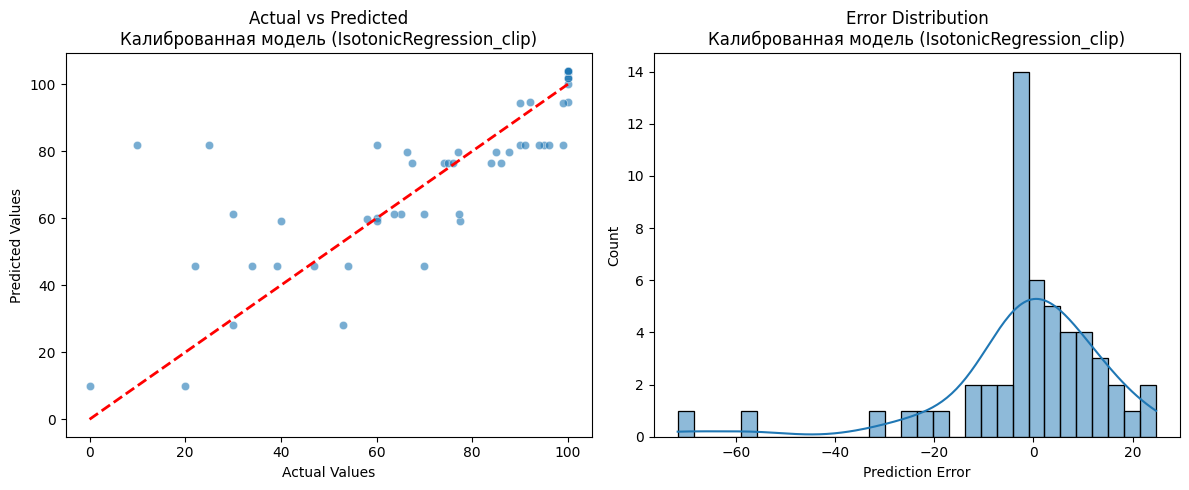

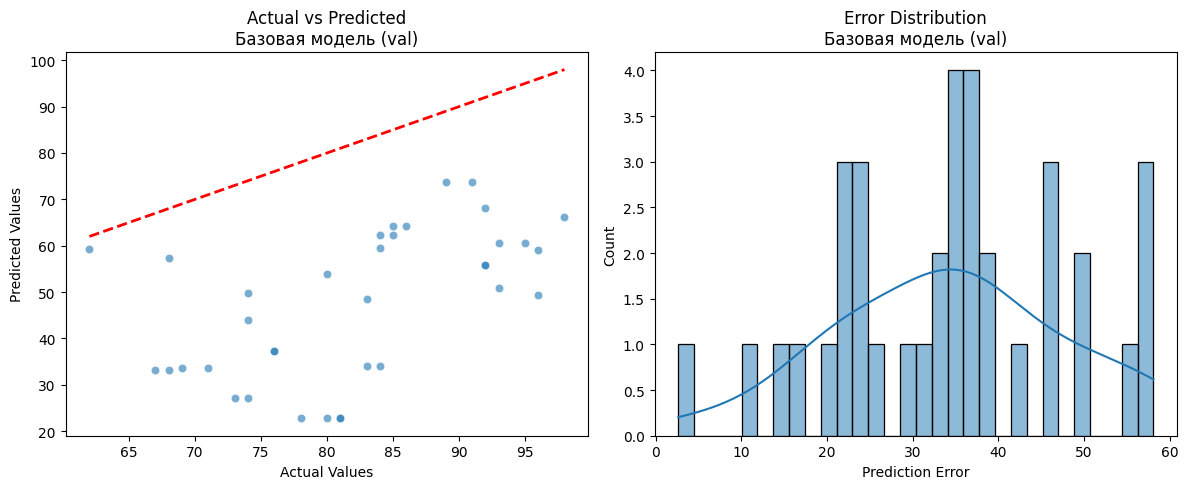

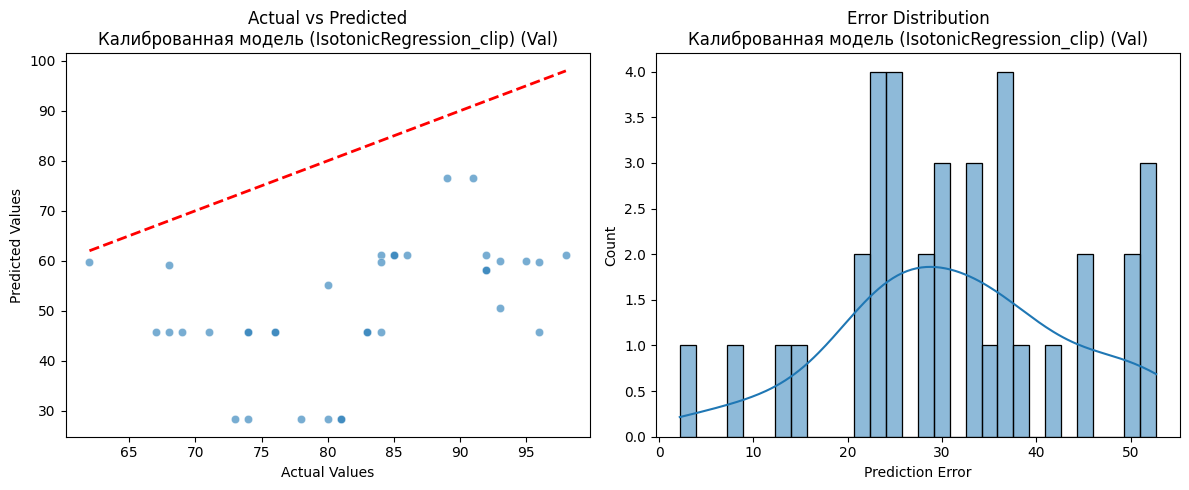

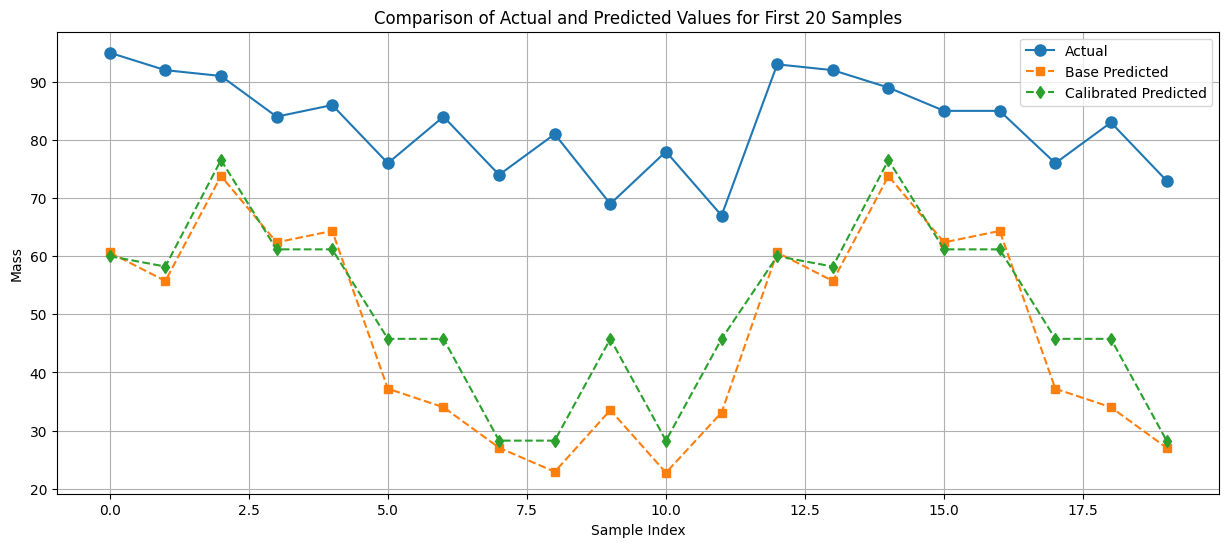


Обучающая выборка (топ-10 наибольших ошибок):
     True_Value  Predicted  Absolute_Error
42         70.0  76.537500        6.537500
23         87.5  81.705909        5.794091
35         87.5  81.705909        5.794091
46         87.5  81.705909        5.794091
98         87.5  81.705909        5.794091
81         87.5  81.705909        5.794091
87         87.5  81.705909        5.794091
66         87.5  81.705909        5.794091
181        87.5  81.705909        5.794091
150        87.5  81.705909        5.794091

Средняя ошибка в топе: 5.86843181818182

Тестовая выборка (топ-10 наибольших ошибок):
    True_Value   Predicted  Absolute_Error
22        95.0   59.166667       13.294091
52        94.0   76.537500       12.294091
45        20.0   79.850000       10.000000
16        86.0   59.166667        9.462500
2         90.0   45.783750        8.294091
17        84.0  101.800000        7.462500
23        85.0   10.000000        5.150000
34        90.0  103.976744        4.500000
25    

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor  # Возвращаем GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (mean_absolute_error, r2_score,
                           median_absolute_error, mean_squared_error)
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, TargetEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, Ridge  # Для Platt Scaling
from sklearn.preprocessing import PolynomialFeatures  # Для Beta Calibration
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

train_df = pd.read_excel('/content/big_train_no_duples.xlsx')

X = train_df.drop(columns=['mass'])
y = train_df['mass']

bins = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 99, 110]
y_binned = pd.cut(y, bins=bins, labels=False, duplicates='drop')

plt.figure(figsize=(10, 5))
sns.boxplot(x=y_binned, y=y)
plt.title('Распределение по бинам стратификации')
plt.show()

print("Original y:", y.values)
print("Binned y:  ", y_binned.values)
bin_counts = y_binned.value_counts().sort_index()
print(bin_counts)

# Пайплайн для препроцессинга
numerical_cols = ['% second component', 'day', 'ph']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality', 'porosity', 'in vivo', 'enzymatic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X, y)



# Разделение данных на train/test до применения ADASYN
X_train, X_test, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X_preprocessed, y, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned,
)

adasyn = ADASYN(sampling_strategy='minority',
                n_neighbors=1,
                random_state=42)

X_train_resampled, y_train_resampled_binned = adasyn.fit_resample(X_train, y_train_binned)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_resampled_binned
)

bin_centers = []
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]
    median_val = (lower + upper) / 2
    bin_centers.append(median_val)

y_train_resampled = np.array([bin_centers[int(cls)] for cls in y_train_resampled_binned])

print("\nРаспределение после ADASYN (только на тренировочных данных):")
print(pd.Series(y_train_resampled_binned).value_counts().sort_index())

X_train_preprocessed = X_train_resampled
X_test_preprocessed = X_test

# Параметры для GradientBoostingRegressor
param_dist = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_depth': [3, 6, 9, 12],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__random_state': [42]
}

base_model = Pipeline([
    ('regressor', GradientBoostingRegressor())
])

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Обучение модели с Randomized Grid Search...")
random_search.fit(X_train_preprocessed, y_train_resampled, regressor__sample_weight=sample_weights)

print("Лучшие параметры:", random_search.best_params_)

base_model = random_search.best_estimator_

# Базовые предсказания для калибровки
base_pred_train = base_model.predict(X_train_preprocessed)
base_pred_test = base_model.predict(X_test_preprocessed)

base_pred_all = np.concatenate([base_pred_train, base_pred_test])
y_all = np.concatenate([y_train_resampled, y_test])

# Определяем калибраторы и их параметры
calibrators = {
    'IsotonicRegression_clip': {
        'calibrator': IsotonicRegression(out_of_bounds='clip'),
        'description': 'Isotonic Regression (out_of_bounds=clip)'
    },
    'IsotonicRegression_raise': {
        'calibrator': IsotonicRegression(out_of_bounds='raise'),
        'description': 'Isotonic Regression (out_of_bounds=raise)'
    },
    'PlattScaling_Linear': {
        'calibrator': LinearRegression(),
        'description': 'Platt Scaling (Linear Regression)'
    },
    'PlattScaling_Ridge_alpha1': {
        'calibrator': Ridge(alpha=1.0),
        'description': 'Platt Scaling (Ridge, alpha=1.0)'
    },
    'PlattScaling_Ridge_alpha10': {
        'calibrator': Ridge(alpha=10.0),
        'description': 'Platt Scaling (Ridge, alpha=10.0)'
    },
    'BetaCalibration_Poly1': {
        'calibrator': make_pipeline(PolynomialFeatures(degree=1), LinearRegression()),
        'description': 'Beta Calibration (Polynomial degree=1)'
    },
    'BetaCalibration_Poly2': {
        'calibrator': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
        'description': 'Beta Calibration (Polynomial degree=2)'
    },
    'BetaCalibration_Poly3': {
        'calibrator': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
        'description': 'Beta Calibration (Polynomial degree=3)'
    }
}

# Словарь для хранения результатов калибрации
calibration_results = {}

val_df = pd.read_excel('/content/test_no_psb.xlsx')
val_df.drop(columns=['prev_day', 'prev_day_mass'], inplace=True)

X_val = val_df.drop(columns=['mass'])
y_val = val_df['mass']
X_val_preprocessed = preprocessor.transform(X_val)

# Базовые предсказания для всех наборов
y_pred_train_base = base_model.predict(X_train_preprocessed)
y_pred_test_base = base_model.predict(X_test_preprocessed)
y_pred_val_base = base_model.predict(X_val_preprocessed)

# Эксперименты с калибраторами
best_calibrator_name = None
best_mae_val = float('inf')

for calib_name, config in calibrators.items():
    print(f"\nКалибровка с {config['description']}...")

    # Фитим калибратор
    calibrator = config['calibrator']
    try:
        # Для IsotonicRegression и Platt Scaling нужно преобразовать base_pred_all в 2D массив
        calibrator.fit(base_pred_all.reshape(-1, 1), y_all)
    except ValueError as e:
        print(f"Ошибка при калибровке {calib_name}: {e}")
        continue

    # Предсказания с калибровкой
    def calibrated_predict(X):
        base_pred = base_model.predict(X)
        try:
            return calibrator.predict(base_pred.reshape(-1, 1))
        except ValueError as e:
            print(f"Ошибка при предсказании с {calib_name}: {e}")
            return base_pred  # Возвращаем базовые предсказания в случае ошибки

    y_pred_train_cal = calibrated_predict(X_train_preprocessed)
    y_pred_test_cal = calibrated_predict(X_test_preprocessed)
    y_pred_val_cal = calibrated_predict(X_val_preprocessed)

    # Метрики
    def print_metrics(y_true, y_pred, model_name):
        mae = mean_absolute_error(y_true, y_pred)
        medae = median_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        rmse_val = rmse(y_true, y_pred)
        print(f"\n{model_name} результаты:")
        print(f"{'Метрика':<15}{'Значение':<15}")
        print(f"{'MAE':<15}{mae:.4f}")
        print(f"{'MedAE':<15}{medae:.4f}")
        print(f"{'R²':<15}{r2:.4f}")
        print(f"{'RMSE':<15}{rmse_val:.4f}")
        return mae

    # Выводим метрики для базовой модели (один раз)
    if calib_name == list(calibrators.keys())[0]:
        print_metrics(y_train_resampled, y_pred_train_base, "Базовая модель (train)")
        print_metrics(y_test, y_pred_test_base, "Базовая модель (test)")
        print_metrics(y_val, y_pred_val_base, "Базовая модель (val)")

    # Метрики для калиброванной модели
    mae_train = print_metrics(y_train_resampled, y_pred_train_cal, f"Калиброванная модель ({calib_name}) (train)")
    mae_test = print_metrics(y_test, y_pred_test_cal, f"Калиброванная модель ({calib_name}) (test)")
    mae_val = print_metrics(y_val, y_pred_val_cal, f"Калиброванная модель ({calib_name}) (val)")

    calibration_results[calib_name] = {
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mae_val': mae_val,
        'calibrator': calibrator,
        'y_pred_train_cal': y_pred_train_cal,
        'y_pred_test_cal': y_pred_test_cal,
        'y_pred_val_cal': y_pred_val_cal
    }

    # Обновляем лучшую калибрацию по MAE на валидационном наборе
    if mae_val < best_mae_val:
        best_mae_val = mae_val
        best_calibrator_name = calib_name

# Выбираем лучшую калибрацию
print(f"\nЛучший калибратор: {calibrators[best_calibrator_name]['description']} с MAE на валидации: {best_mae_val:.4f}")

# Используем лучший калибратор для визуализации и анализа ошибок
best_calibrator_info = calibration_results[best_calibrator_name]
calibrator = best_calibrator_info['calibrator']
y_pred_train_cal = best_calibrator_info['y_pred_train_cal']
y_pred_test_cal = best_calibrator_info['y_pred_test_cal']
y_pred_val_cal = best_calibrator_info['y_pred_val_cal']

def calibrated_predict(X):
    base_pred = base_model.predict(X)
    return calibrator.predict(base_pred.reshape(-1, 1))

# Визуализация результатов
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted\n{title}')

    plt.subplot(1, 2, 2)
    errors = y_true - y_pred
    sns.histplot(errors, kde=True, bins=30)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title(f'Error Distribution\n{title}')

    plt.tight_layout()
    plt.show()

plot_results(y_test, y_pred_test_base, "Базовая модель")
plot_results(y_test, y_pred_test_cal, f"Калиброванная модель ({best_calibrator_name})")
plot_results(y_val, y_pred_val_base, "Базовая модель (val)")
plot_results(y_val, y_pred_val_cal, f"Калиброванная модель ({best_calibrator_name}) (Val)")

# Сравнение первых 20 образцов
plt.figure(figsize=(15, 6))
sample_indices = range(min(20, len(y_val)))
plt.plot(sample_indices, y_val[sample_indices], 'o-', label='Actual', markersize=8)
plt.plot(sample_indices, y_pred_val_base[sample_indices], 's--', label='Base Predicted', markersize=6)
plt.plot(sample_indices, y_pred_val_cal[sample_indices], 'd--', label='Calibrated Predicted', markersize=6)
plt.xlabel('Sample Index')
plt.ylabel('Mass')
plt.title('Comparison of Actual and Predicted Values for First 20 Samples')
plt.legend()
plt.grid(True)
plt.show()

train_errors = abs(y_train_resampled - y_pred_train_cal)
test_errors = abs(y_test - y_pred_test_cal)
val_errors = abs(y_val - y_pred_val_cal)

# 1. Сначала получим названия всех фичей после препроцессинга
num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = list(num_features) + list(cat_features)

# 2. Создадим функцию для сопоставления индексов
def get_original_indices(X_resampled, X_original):
    """Находит соответствие между сэмплами после ADASYN и оригинальными данными"""
    from sklearn.neighbors import NearestNeighbors

    # Находим ближайших соседей для сгенерированных сэмплов
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_original)
    _, indices = nbrs.kneighbors(X_resampled)

    return indices.flatten()

# 3. Получаем индексы оригинальных данных для train выборки
original_indices = get_original_indices(X_train_resampled, X_preprocessed)

# 4. Создаем DataFrame с ошибками для train
train_df_with_errors = pd.DataFrame(X_train_resampled, columns=all_feature_names)
train_df_with_errors['True_Value'] = y_train_resampled
train_df_with_errors['Predicted'] = y_pred_train_cal
train_df_with_errors['Absolute_Error'] = train_errors

# 5. Добавляем оригинальные категориальные признаки
for col in categorical_cols:
    train_df_with_errors[col] = train_df.iloc[original_indices][col].values

# 6. Аналогично для test (если нужно)
test_df_with_errors = pd.DataFrame(X_test, columns=all_feature_names)
test_df_with_errors['True_Value'] = y_test
test_df_with_errors['Predicted'] = y_pred_test_cal
test_df_with_errors['Absolute_Error'] = test_errors

val_df_with_errors = pd.DataFrame(X_val, columns=all_feature_names)
val_df_with_errors['True_Value'] = y_val
val_df_with_errors['Predicted'] = y_pred_val_cal
val_df_with_errors['Absolute_Error'] = val_errors

# 7. Функция для вывода топ ошибок
def print_top_errors(error_df, title, n=10):
    top_errors = error_df.sort_values('Absolute_Error', ascending=False).head(n)
    print(f"\n{title} (топ-{n} наибольших ошибок):")
    cols_to_show = ['True_Value', 'Predicted', 'Absolute_Error']
    print(top_errors[cols_to_show])
    print("\nСредняя ошибка в топе:", top_errors['Absolute_Error'].mean())

# 8. Выводим результаты
print_top_errors(train_df_with_errors, "Обучающая выборка")
print_top_errors(test_df_with_errors, "Тестовая выборка")
print_top_errors(val_df_with_errors, "Диссертация")

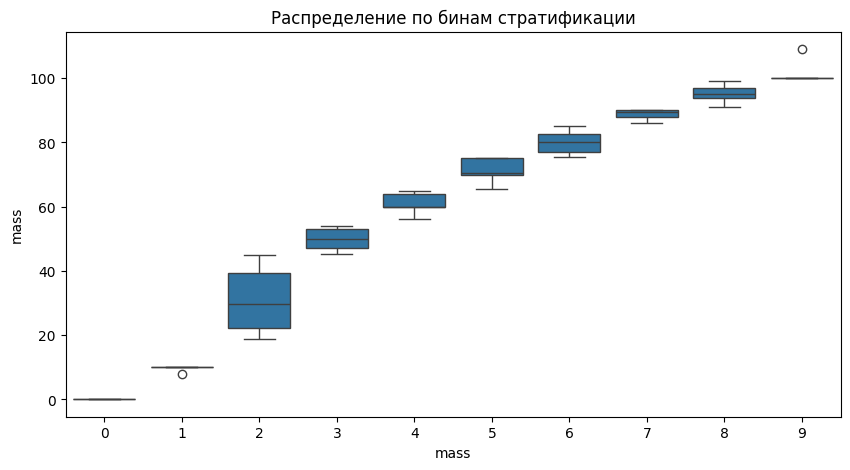

Original y: [100.    95.    90.    85.    80.    75.    70.    65.    60.   100.
  98.    96.    94.    92.    90.    88.    86.    84.    90.    80.
  70.    60.    95.    85.    75.    65.    98.    90.    80.    70.
  95.    85.    75.    65.    90.    80.    70.    60.    95.    85.
  75.    65.    80.    60.    40.    20.    75.    50.    30.    10.
 100.    97.    94.    91.    88.    85.    82.    79.    76.   100.
  99.    98.    97.    96.    95.    94.    93.    92.    77.5   77.5
  20.    33.    10.    20.    40.    37.5   60.    60.    25.   100.
 100.    75.    45.   100.   100.   100.   100.    63.    53.    27.
  61.    53.    29.    67.    54.    29.    92.    88.    86.    78.
  66.    70.    64.    84.   109.    96.    77.    93.    70.    45.
  39.    88.    94.    74.    80.    75.    37.    40.    29.    76.
  88.    47.    62.    56.    22.    21.    19.    50.    64.    34.
  40.    40.   100.   100.   100.   100.   100.   100.    80.    76.
  75.    95.    75.  

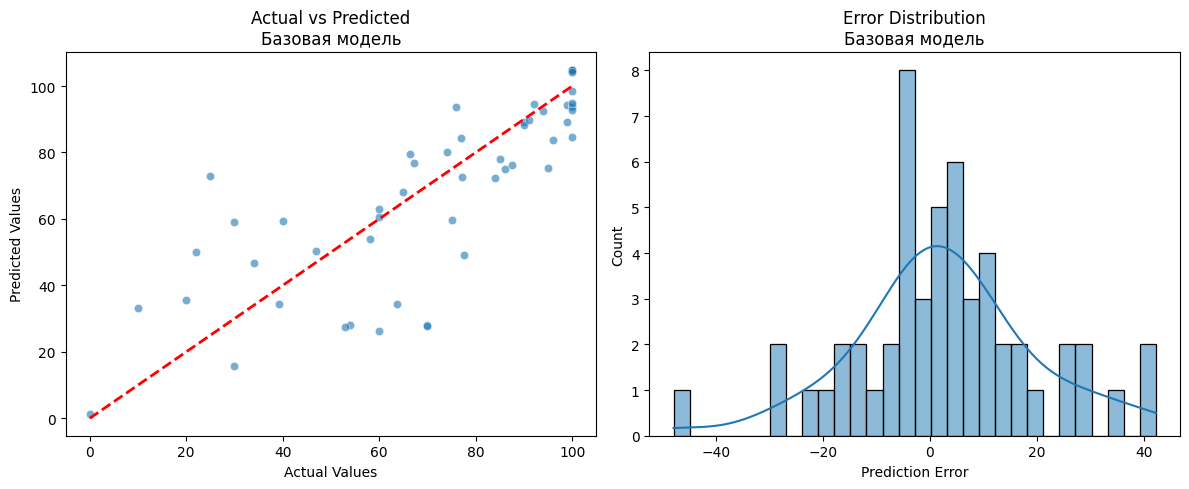

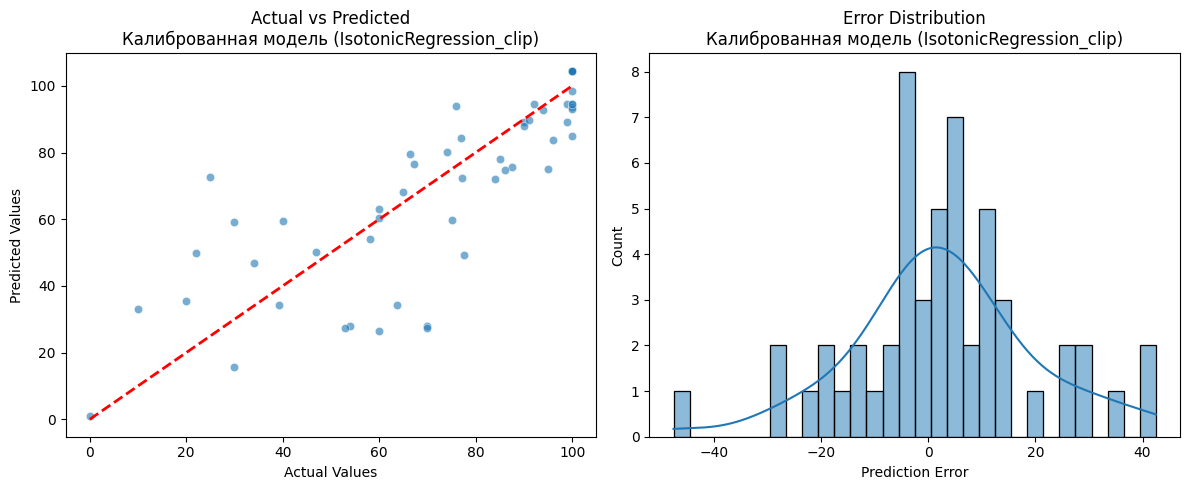

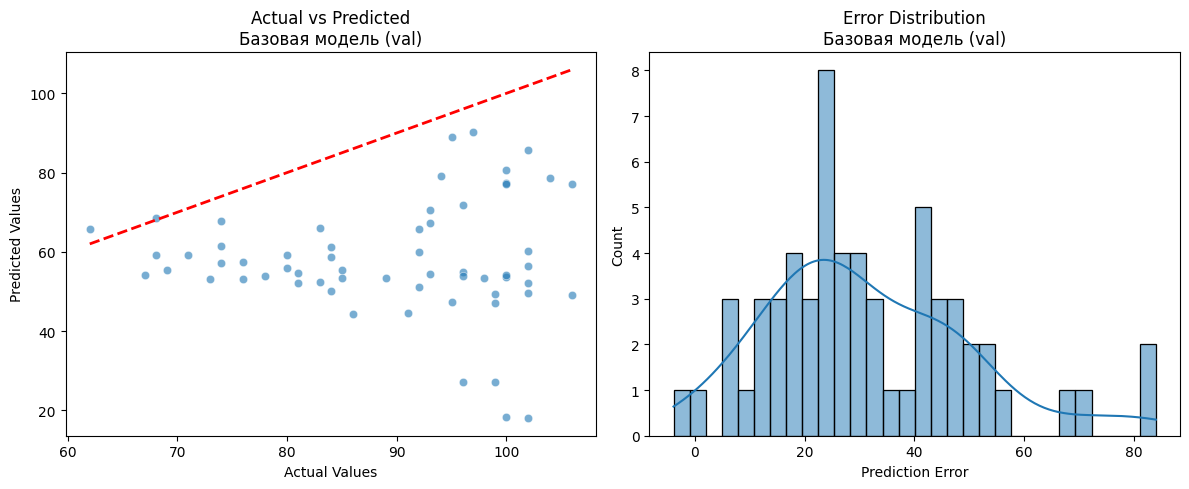

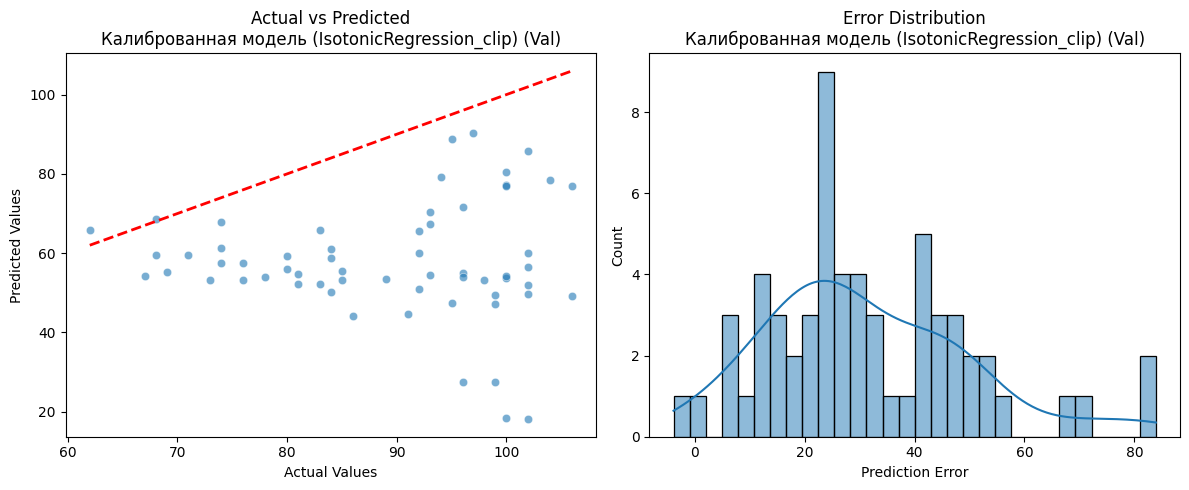

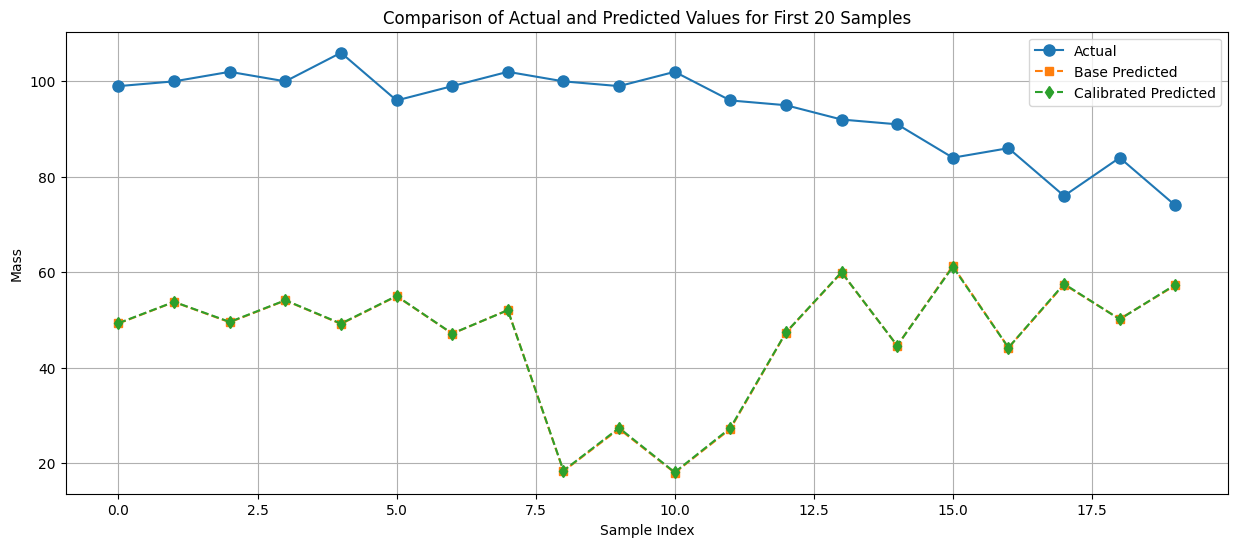

Shape of train_errors: (248,)
Shape of test_errors: (53,)
Shape of val_errors: (60,)

Обучающая выборка (топ-10 наибольших ошибок):
    True_Value  Predicted  Absolute_Error
7         80.0       75.0             5.0
42        70.0       75.0             5.0
2         27.5       27.5             0.0
0          5.5        5.5             0.0
3          0.0        0.0             0.0
4         70.0       70.0             0.0
5        104.5      104.5             0.0
1         27.5       27.5             0.0
8         60.0       60.0             0.0
9         27.5       27.5             0.0

Средняя ошибка в топе: 1.0

Тестовая выборка (топ-10 наибольших ошибок):
    True_Value   Predicted  Absolute_Error
22        95.0   49.126760       20.026496
45        20.0   84.367336       15.477734
46        75.0   54.110964       15.090632
48        30.0   27.500000       14.188176
17        84.0   94.500000       11.864170
16        86.0   60.425502       11.336956
23        85.0    1.078285     

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

# RMSE function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Load data
train_df = pd.read_excel('/content/big_train_no_duples.xlsx')
X = train_df.drop(columns=['mass'])
y = train_df['mass']

# Binning and visualization
bins = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 99, 110]
y_binned = pd.cut(y, bins=bins, labels=False, duplicates='drop')

plt.figure(figsize=(10, 5))
sns.boxplot(x=y_binned, y=y)
plt.title('Распределение по бинам стратификации')
plt.show()

print("Original y:", y.values)
print("Binned y:  ", y_binned.values)
bin_counts = y_binned.value_counts().sort_index()
print(bin_counts)

# Define columns
numerical_cols = ['% second component', 'day', 'ph']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality',
                   'porosity', 'in vivo', 'enzymatic', 'form_type', 'environment_type']

# Create preprocessing pipeline with PCA
preprocessor = Pipeline(steps=[
    ('col_transformer', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('robust', RobustScaler()),
                ('scaler', Normalizer())
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols)
        ]
    )),
    ('pca', PCA(n_components=0.95))
])

# Apply preprocessing and PCA
X_preprocessed = preprocessor.fit_transform(X)

# Function to compute and print PCA feature importance
def print_pca_feature_importance(preprocessor, numerical_cols, categorical_cols):
    col_transformer = preprocessor.named_steps['col_transformer']
    pca = preprocessor.named_steps['pca']

    num_features = numerical_cols
    cat_transformer = col_transformer.named_transformers_['cat']
    onehot_encoder = cat_transformer.named_steps['onehot']
    cat_features = onehot_encoder.get_feature_names_out(categorical_cols)
    all_features = list(num_features) + list(cat_features)

    loadings = pca.components_.T
    explained_variance = pca.explained_variance_
    total_variance = np.sum(explained_variance)
    weights = explained_variance / total_variance
    feature_importance = np.sum((loadings ** 2) * weights, axis=1)

    aggregated_importance = []
    for col in numerical_cols + categorical_cols:
        if col in numerical_cols:
            importance = feature_importance[all_features.index(col)]
            aggregated_importance.append((col, importance))
        else:
            related_features = [f for f in all_features if f.startswith(f"{col}_")]
            importance = sum(feature_importance[all_features.index(f)] for f in related_features)
            aggregated_importance.append((col, importance))

    importance_df = pd.DataFrame(aggregated_importance, columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nPCA Feature Importance:")
    print(f"{'Feature':<30}{'Importance':<15}")
    print("-" * 45)
    for _, row in importance_df.iterrows():
        print(f"{row['Feature']:<30}{row['Importance']:.6f}")

    return importance_df

# Print PCA feature importance
importance_df = print_pca_feature_importance(preprocessor, numerical_cols, categorical_cols)

# Split data
X_train, X_test, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X_preprocessed, y, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned,
)

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)
X_train_resampled, y_train_resampled_binned = adasyn.fit_resample(X_train, y_train_binned)

# Map binned classes to bin centers
bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]
y_train_resampled = np.array([bin_centers[int(cls)] for cls in y_train_resampled_binned])

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_resampled_binned)

print("\nРаспределение после ADASYN (только на тренировочных данных):")
print(pd.Series(y_train_resampled_binned).value_counts().sort_index())

# Prepare data
X_train_preprocessed = X_train_resampled
X_test_preprocessed = X_test

# Debug: Print shapes before model training
print(f"Shape of X_train_preprocessed: {X_train_preprocessed.shape}")
print(f"Shape of y_train_resampled: {y_train_resampled.shape}")
print(f"Shape of X_test_preprocessed: {X_test_preprocessed.shape}")
print(f"Shape of y_test: {y_test.shape}")

# GradientBoostingRegressor parameters and RandomizedSearchCV
param_dist = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_depth': [3, 6, 9, 12],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__random_state': [42]
}

base_model = Pipeline([
    ('regressor', GradientBoostingRegressor())
])

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Обучение модели с Randomized Grid Search...")
random_search.fit(X_train_resampled, y_train_resampled, regressor__sample_weight=sample_weights)

print("Лучшие параметры:", random_search.best_params_)
base_model = random_search.best_estimator_

# Validation data
val_df = pd.read_excel('/content/final_test.xlsx')
val_df.drop(columns=['prev_day', 'prev_day_mass'], inplace=True)
X_val = val_df.drop(columns=['mass'])
y_val = val_df['mass']
X_val_preprocessed = preprocessor.transform(X_val)

# Debug: Print validation shapes
print(f"Shape of X_val_preprocessed: {X_val_preprocessed.shape}")
print(f"Shape of y_val: {y_val.shape}")

# Base predictions
y_pred_train_base = base_model.predict(X_train_preprocessed)
y_pred_test_base = base_model.predict(X_test_preprocessed)
y_pred_val_base = base_model.predict(X_val_preprocessed)

# Debug: Print base prediction shapes
print(f"Shape of y_pred_train_base: {y_pred_train_base.shape}")
print(f"Shape of y_pred_test_base: {y_pred_test_base.shape}")
print(f"Shape of y_pred_val_base: {y_pred_val_base.shape}")

# Assert base prediction shapes
assert y_pred_train_base.shape[0] == y_train_resampled.shape[0], \
    f"y_pred_train_base ({y_pred_train_base.shape[0]}) and y_train_resampled ({y_train_resampled.shape[0]}) have different lengths"
assert y_pred_test_base.shape[0] == y_test.shape[0], \
    f"y_pred_test_base ({y_pred_test_base.shape[0]}) and y_test ({y_test.shape[0]}) have different lengths"
assert y_pred_val_base.shape[0] == y_val.shape[0], \
    f"y_pred_val_base ({y_pred_val_base.shape[0]}) and y_val ({y_val.shape[0]}) have different lengths"

# Calibration
calibrators = {
    'IsotonicRegression_clip': {
        'calibrator': IsotonicRegression(out_of_bounds='clip'),
        'description': 'Isotonic Regression (out_of_bounds=clip)'
    },
    'IsotonicRegression_raise': {
        'calibrator': IsotonicRegression(out_of_bounds='raise'),
        'description': 'Isotonic Regression (out_of_bounds=raise)'
    },
    'PlattScaling_Linear': {
        'calibrator': LinearRegression(),
        'description': 'Platt Scaling (Linear Regression)'
    },
    'PlattScaling_Ridge_alpha1': {
        'calibrator': Ridge(alpha=1.0),
        'description': 'Platt Scaling (Ridge, alpha=1.0)'
    },
    'PlattScaling_Ridge_alpha10': {
        'calibrator': Ridge(alpha=10.0),
        'description': 'Platt Scaling (Ridge, alpha=10.0)'
    },
    'BetaCalibration_Poly1': {
        'calibrator': make_pipeline(PolynomialFeatures(degree=1), LinearRegression()),
        'description': 'Beta Calibration (Polynomial degree=1)'
    },
    'BetaCalibration_Poly2': {
        'calibrator': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
        'description': 'Beta Calibration (Polynomial degree=2)'
    },
    'BetaCalibration_Poly3': {
        'calibrator': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
        'description': 'Beta Calibration (Polynomial degree=3)'
    }
}

calibration_results = {}
best_calibrator_name = None
best_mae_val = float('inf')

for calib_name, config in calibrators.items():
    print(f"\nКалибровка с {config['description']}...")

    # Fit calibrator on resampled training data
    calibrator = config['calibrator']
    try:
        calibrator.fit(y_pred_train_base.reshape(-1, 1), y_train_resampled)
    except ValueError as e:
        print(f"Ошибка при калибровке {calib_name}: {e}")
        continue

    # Calibrated predictions
    def calibrated_predict(X, name=calib_name):
        base_pred = base_model.predict(X)
        try:
            calibrated = calibrator.predict(base_pred.reshape(-1, 1))
            print(f"Shape of calibrated predictions ({name}): {calibrated.shape}")
            return calibrated
        except ValueError as e:
            print(f"Ошибка при предсказании с {name}: {e}. Using base predictions.")
            return base_pred

    # Generate calibrated predictions
    y_pred_train_cal = calibrated_predict(X_train_preprocessed, calib_name)
    y_pred_test_cal = calibrated_predict(X_test_preprocessed, calib_name)
    y_pred_val_cal = calibrated_predict(X_val_preprocessed, calib_name)

    # Assert calibrated prediction shapes
    assert y_pred_train_cal.shape[0] == y_train_resampled.shape[0], \
        f"y_pred_train_cal ({y_pred_train_cal.shape[0]}) and y_train_resampled ({y_train_resampled.shape[0]}) have different lengths for {calib_name}"
    assert y_pred_test_cal.shape[0] == y_test.shape[0], \
        f"y_pred_test_cal ({y_pred_test_cal.shape[0]}) and y_test ({y_test.shape[0]}) have different lengths for {calib_name}"
    assert y_pred_val_cal.shape[0] == y_val.shape[0], \
        f"y_pred_val_cal ({y_pred_val_cal.shape[0]}) and y_val ({y_val.shape[0]}) have different lengths for {calib_name}"

    # Metrics
    def print_metrics(y_true, y_pred, model_name):
        mae = mean_absolute_error(y_true, y_pred)
        medae = median_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        rmse_val = rmse(y_true, y_pred)
        print(f"\n{model_name} результаты:")
        print(f"{'Метрика':<15}{'Значение':<15}")
        print(f"{'MAE':<15}{mae:.4f}")
        print(f"{'MedAE':<15}{medae:.4f}")
        print(f"{'R²':<15}{r2:.4f}")
        print(f"{'RMSE':<15}{rmse_val:.4f}")
        return mae

    # Base model metrics (print once)
    if calib_name == list(calibrators.keys())[0]:
        print_metrics(y_train_resampled, y_pred_train_base, "Базовая модель (train)")
        print_metrics(y_test, y_pred_test_base, "Базовая модель (test)")
        print_metrics(y_val, y_pred_val_base, "Базовая модель (val)")

    # Calibrated model metrics
    mae_train = print_metrics(y_train_resampled, y_pred_train_cal, f"Калиброванная модель ({calib_name}) (train)")
    mae_test = print_metrics(y_test, y_pred_test_cal, f"Калиброванная модель ({calib_name}) (test)")
    mae_val = print_metrics(y_val, y_pred_val_cal, f"Калиброванная модель ({calib_name}) (val)")

    calibration_results[calib_name] = {
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mae_val': mae_val,
        'calibrator': calibrator,
        'y_pred_train_cal': y_pred_train_cal,
        'y_pred_test_cal': y_pred_test_cal,
        'y_pred_val_cal': y_pred_val_cal
    }

    if mae_val < best_mae_val:
        best_mae_val = mae_val
        best_calibrator_name = calib_name

print(f"\nЛучший калибратор: {calibrators[best_calibrator_name]['description']} с MAE на валидации: {best_mae_val:.4f}")

# Use best calibrator
best_calibrator_info = calibration_results[best_calibrator_name]
calibrator = best_calibrator_info['calibrator']
y_pred_train_cal = best_calibrator_info['y_pred_train_cal']
y_pred_test_cal = best_calibrator_info['y_pred_test_cal']
y_pred_val_cal = best_calibrator_info['y_pred_val_cal']

def calibrated_predict(X):
    base_pred = base_model.predict(X)
    return calibrator.predict(base_pred.reshape(-1, 1))

# Visualization
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted\n{title}')
    plt.subplot(1, 2, 2)
    errors = y_true - y_pred
    sns.histplot(errors, kde=True, bins=30)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title(f'Error Distribution\n{title}')
    plt.tight_layout()
    plt.show()

plot_results(y_test, y_pred_test_base, "Базовая модель")
plot_results(y_test, y_pred_test_cal, f"Калиброванная модель ({best_calibrator_name})")
plot_results(y_val, y_pred_val_base, "Базовая модель (val)")
plot_results(y_val, y_pred_val_cal, f"Калиброванная модель ({best_calibrator_name}) (Val)")

# Compare first 20 samples
plt.figure(figsize=(15, 6))
sample_indices = range(min(20, len(y_val)))
plt.plot(sample_indices, y_val[sample_indices], 'o-', label='Actual', markersize=8)
plt.plot(sample_indices, y_pred_val_base[sample_indices], 's--', label='Base Predicted', markersize=6)
plt.plot(sample_indices, y_pred_val_cal[sample_indices], 'd--', label='Calibrated Predicted', markersize=6)
plt.xlabel('Sample Index')
plt.ylabel('Mass')
plt.title('Comparison of Actual and Predicted Values for First 20 Samples')
plt.legend()
plt.grid(True)
plt.show()

# Error analysis
train_errors = abs(y_train_resampled - y_pred_train_cal)
test_errors = abs(y_test - y_pred_test_cal)
val_errors = abs(y_val - y_pred_val_cal)

# Debug: Print error shapes
print(f"Shape of train_errors: {train_errors.shape}")
print(f"Shape of test_errors: {test_errors.shape}")
print(f"Shape of val_errors: {val_errors.shape}")

# Create feature names for PCA components
n_components = preprocessor.named_steps['pca'].n_components_
all_feature_names = [f'PC{i+1}' for i in range(n_components)]

# Map resampled samples to original data
def get_original_indices(X_resampled, X_original):
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_original)
    _, indices = nbrs.kneighbors(X_resampled)
    return indices.flatten()

original_indices = get_original_indices(X_train_resampled, X_preprocessed)

# Create DataFrame with errors for train
train_df_with_errors = pd.DataFrame(X_train_resampled, columns=all_feature_names)
train_df_with_errors['True_Value'] = y_train_resampled
train_df_with_errors['Predicted'] = y_pred_train_cal
train_df_with_errors['Absolute_Error'] = train_errors

# Add original categorical features
for col in categorical_cols:
    train_df_with_errors[col] = train_df.iloc[original_indices][col].values

# For test data
test_df_with_errors = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)
test_df_with_errors['True_Value'] = y_test
test_df_with_errors['Predicted'] = y_pred_test_cal
test_df_with_errors['Absolute_Error'] = test_errors

# For validation data
val_df_with_errors = pd.DataFrame(X_val_preprocessed, columns=all_feature_names)
val_df_with_errors['True_Value'] = y_val
val_df_with_errors['Predicted'] = y_pred_val_cal
val_df_with_errors['Absolute_Error'] = val_errors

# Function to print top errors
def print_top_errors(error_df, title, n=10):
    top_errors = error_df.sort_values('Absolute_Error', ascending=False).head(n)
    print(f"\n{title} (топ-{n} наибольших ошибок):")
    cols_to_show = ['True_Value', 'Predicted', 'Absolute_Error']
    print(top_errors[cols_to_show])
    print("\nСредняя ошибка в топе:", top_errors['Absolute_Error'].mean())

# Print results
print_top_errors(train_df_with_errors, "Обучающая выборка")
print_top_errors(test_df_with_errors, "Тестовая выборка")
print_top_errors(val_df_with_errors, "Диссертация")

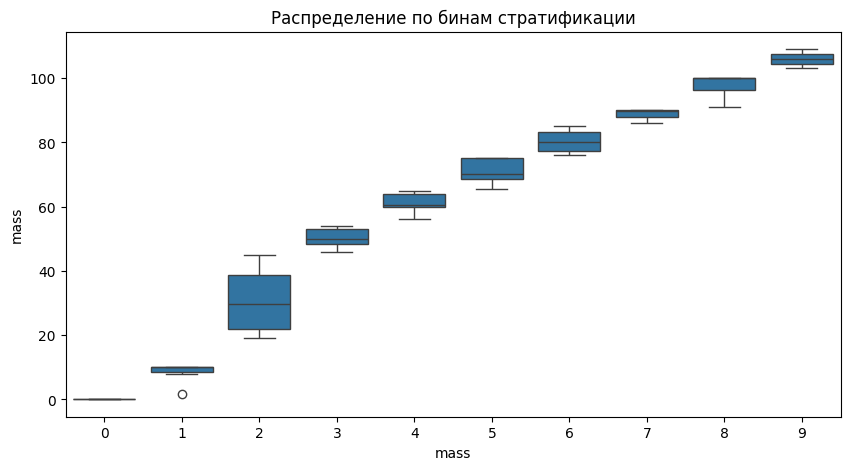

Original y: [100.   95.   90.   85.   80.   75.   70.   65.   60.  100.   98.   96.
  94.   92.   90.   88.   86.   84.   90.   80.   70.   60.   98.   90.
  80.   70.   95.   85.   75.   65.   95.   85.   75.   65.   80.   60.
  40.   20.   75.   50.   30.   10.  100.   97.   94.   91.   88.   85.
  82.   79.   76.  100.   99.   98.   97.   96.   95.   94.   93.   92.
  77.5  77.5  20.   33.   10.   20.   40.   37.5  60.   60.   25.  100.
 100.   75.   45.  100.  100.  100.  100.   63.   53.   27.   61.   53.
  29.   67.   54.   29.   66.   70.   64.   84.  109.   96.   77.   93.
  70.   45.   39.   88.   94.   74.   80.   75.   37.   40.   29.   76.
  88.   47.   62.   56.   22.   21.   19.   80.   50.   64.   34.   40.
  40.  100.  100.  100.  100.   75.   65.  100.  100.   58.   22.   20.
 100.  100.  100.  100.  100.  100.  100.  100.   64.9  92.5  97.  100.
 100.  100.  100.  100.    0.    0.   92.5 100.  100.   71.7  59.4  48.3
 100.   87.6  71.8  62.9 100.   82.6  72.4  66.  10

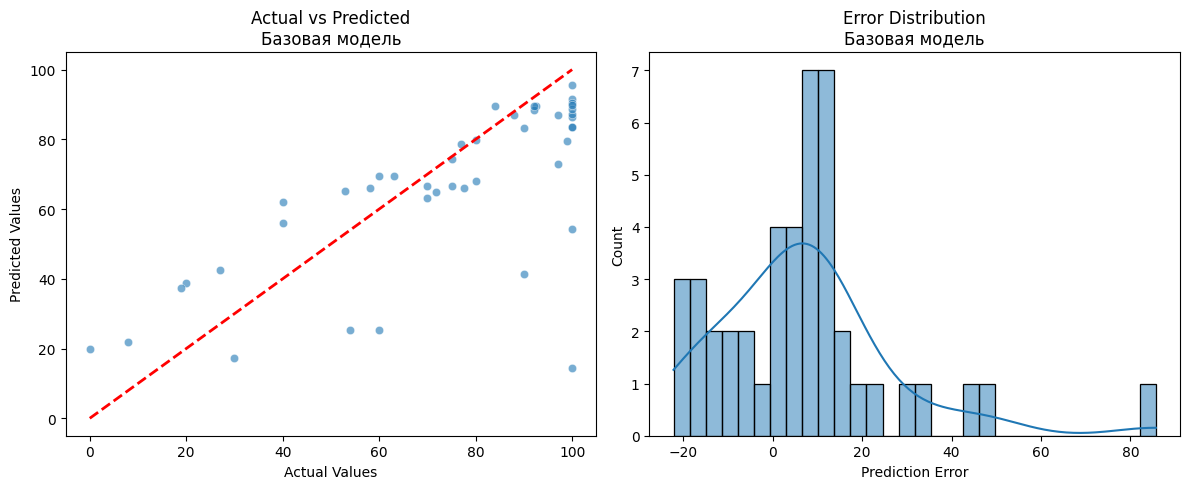

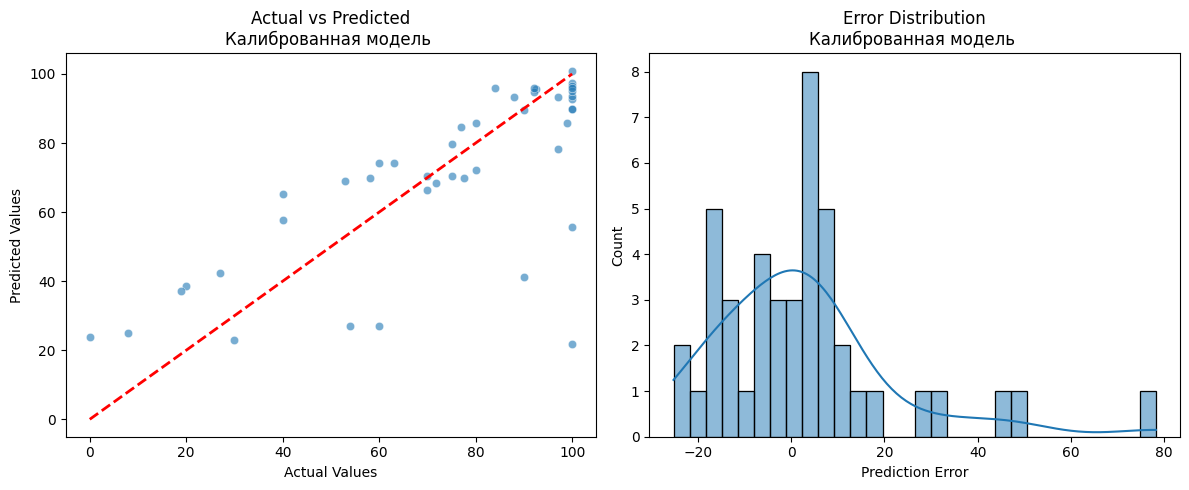

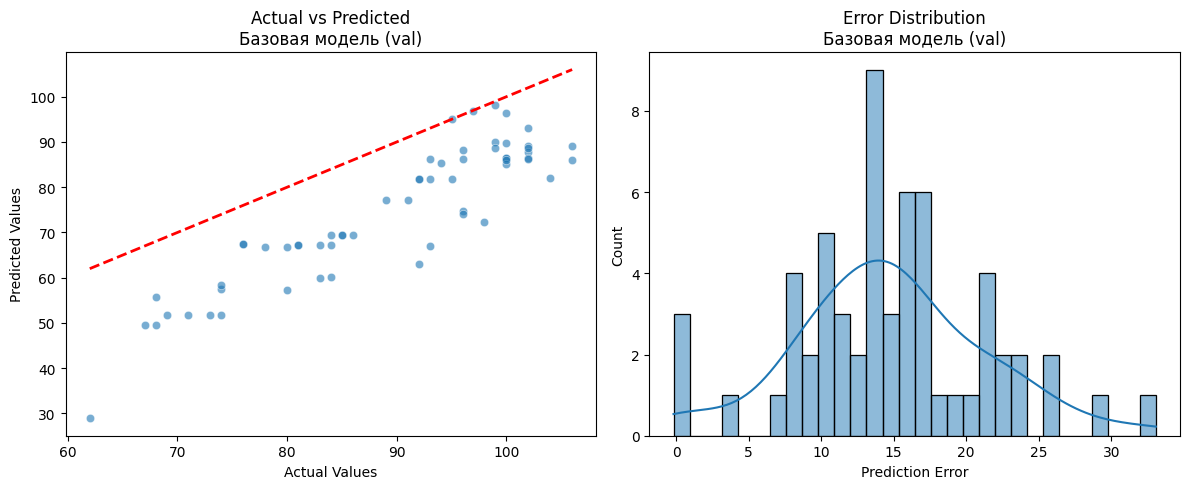

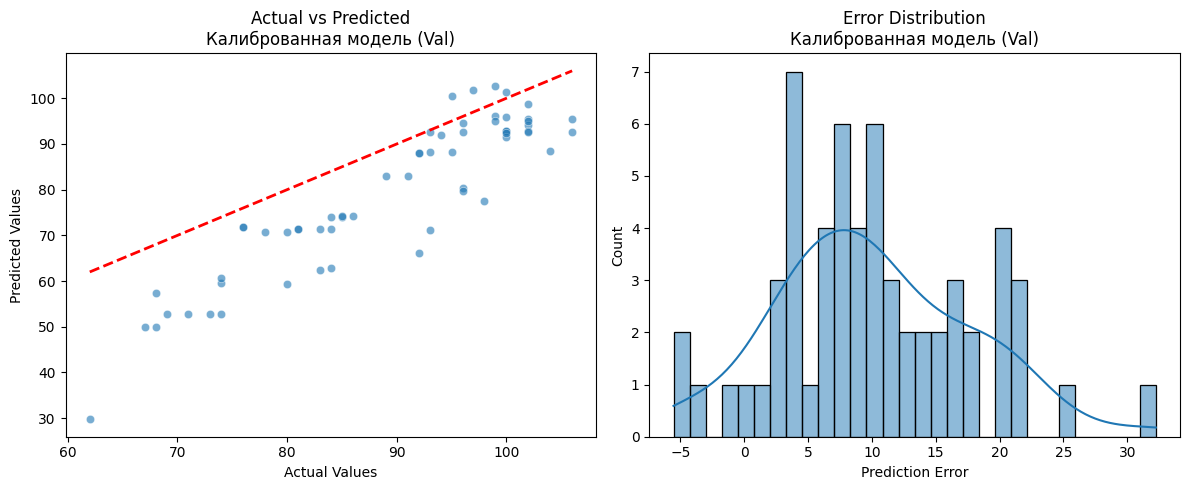

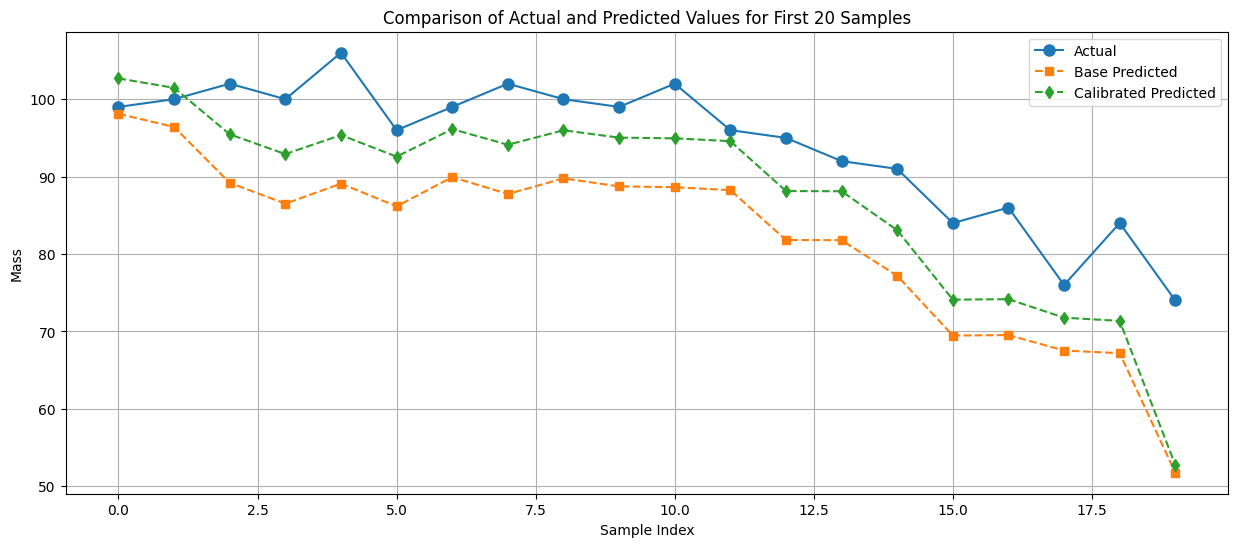


Обучающая выборка (топ-10 наибольших ошибок):
     True_Value  Predicted  Absolute_Error
31         95.0  25.362368       69.637632
102        95.0  28.644734       66.355266
142        95.0  36.745088       58.254912
108        27.5  62.833201       35.333201
67         95.0  63.055691       31.944309
167        95.0  64.386905       30.613095
43          5.5  34.992280       29.492280
79         27.5  55.931540       28.431540
117         0.0  27.016848       27.016848
54          0.0  24.559531       24.559531

Средняя ошибка в топе: 40.16386138453193

Тестовая выборка (топ-10 наибольших ошибок):
    True_Value  Predicted  Absolute_Error
43        97.0  42.393137       18.749407
34        80.0  66.536824        7.746494
19        80.0  94.719650        5.833954
13        92.0  96.524785        3.910111
25        70.0  21.803374        3.463176
9        100.0  89.930185        0.907132
20        70.0  22.838334        0.520743
2         90.0  85.833954        0.368125
0          NaN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor  # Возвращаем GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (mean_absolute_error, r2_score,
                           median_absolute_error, mean_squared_error)
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, TargetEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, Ridge  # Для Platt Scaling
from sklearn.preprocessing import PolynomialFeatures  # Для Beta Calibration
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

train_df = pd.read_excel('preprocessed_train.xlsx')

X = train_df.drop(columns=['mass'])
y = train_df['mass']

bins = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 100, 110]
y_binned = pd.cut(y, bins=bins, labels=False, duplicates='drop')

plt.figure(figsize=(10, 5))
sns.boxplot(x=y_binned, y=y)
plt.title('Распределение по бинам стратификации')
plt.show()

print("Original y:", y.values)
print("Binned y:  ", y_binned.values)
bin_counts = y_binned.value_counts().sort_index()
print(bin_counts)

# Пайплайн для препроцессинга
numerical_cols = ['% second component', 'day', 'ph']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality',
                    'porosity', 'in vivo', 'enzymatic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X, y)



# Разделение данных на train/test до применения ADASYN
X_train, X_test, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X_preprocessed, y, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned,
)
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_resampled_binned
)

adasyn = ADASYN(sampling_strategy='minority',
                n_neighbors=1,
                random_state=42)

X_train_resampled, y_train_resampled_binned = adasyn.fit_resample(X_train, y_train_binned)

bin_centers = []
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]
    median_val = (lower + upper) / 2
    bin_centers.append(median_val)

y_train_resampled = np.array([bin_centers[int(cls)] for cls in y_train_resampled_binned])

print("\nРаспределение после ADASYN (только на тренировочных данных):")
print(pd.Series(y_train_resampled_binned).value_counts().sort_index())

X_train_preprocessed = X_train_resampled
X_test_preprocessed = X_test


base_model = GradientBoostingRegressor(subsample=0.6,
                                            random_state=42, n_estimators=300,
                                            min_samples_split=10,
                                            min_samples_leaf=4,
                                            max_depth=6,learning_rate=0.01)


base_model.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)

# Базовые предсказания для калибровки
base_pred_train = base_model.predict(X_train_preprocessed)
base_pred_test = base_model.predict(X_test_preprocessed)

base_pred_all = np.concatenate([base_pred_train, base_pred_test])
y_all = np.concatenate([y_train_resampled, y_test])

# Словарь для хранения результатов калибрации
calibration_results = {}

val_df = pd.read_excel('preprocessed_test.xlsx')
val_df.drop(columns=['prev_day', 'prev_day_mass'], inplace=True)

X_val = val_df.drop(columns=['mass'])
y_val = val_df['mass']
X_val_preprocessed = preprocessor.transform(X_val)

# Базовые предсказания для всех наборов
y_pred_train_base = base_model.predict(X_train_preprocessed)
y_pred_test_base = base_model.predict(X_test_preprocessed)
y_pred_val_base = base_model.predict(X_val_preprocessed)

calibrator = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
calibrator.fit(base_pred_all.reshape(-1, 1), y_all)

def calibrated_predict(X):
    base_pred = base_model.predict(X)
    try:
        return calibrator.predict(base_pred.reshape(-1, 1))
    except ValueError as e:
        print(f"Ошибка при предсказании с {calib_name}: {e}")
        return base_pred  # Возвращаем базовые предсказания в случае ошибки

y_pred_train_cal = calibrated_predict(X_train_preprocessed)
y_pred_test_cal = calibrated_predict(X_test_preprocessed)
y_pred_val_cal = calibrated_predict(X_val_preprocessed)

# Метрики
def print_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    print(f"\n{model_name} результаты:")
    print(f"{'Метрика':<15}{'Значение':<15}")
    print(f"{'MAE':<15}{mae:.4f}")
    print(f"{'MedAE':<15}{medae:.4f}")
    print(f"{'R²':<15}{r2:.4f}")
    print(f"{'RMSE':<15}{rmse_val:.4f}")
    return mae


print_metrics(y_train_resampled, y_pred_train_base, "Базовая модель (train)")
print_metrics(y_test, y_pred_test_base, "Базовая модель (test)")
print_metrics(y_val, y_pred_val_base, "Базовая модель (val)")

    # Метрики для калиброванной модели
print_metrics(y_train_resampled, y_pred_train_cal, f"Калиброванная модель (train)")
print_metrics(y_test, y_pred_test_cal, f"Калиброванная модель (test)")
print_metrics(y_val, y_pred_val_cal, f"Калиброванная модель (val)")

# Визуализация результатов
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted\n{title}')

    plt.subplot(1, 2, 2)
    errors = y_true - y_pred
    sns.histplot(errors, kde=True, bins=30)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title(f'Error Distribution\n{title}')

    plt.tight_layout()
    plt.show()

plot_results(y_test, y_pred_test_base, "Базовая модель")
plot_results(y_test, y_pred_test_cal, f"Калиброванная модель ")
plot_results(y_val, y_pred_val_base, "Базовая модель (val)")
plot_results(y_val, y_pred_val_cal, f"Калиброванная модель (Val)")

# Сравнение первых 20 образцов
plt.figure(figsize=(15, 6))
sample_indices = range(min(20, len(y_val)))
plt.plot(sample_indices, y_val[sample_indices], 'o-', label='Actual', markersize=8)
plt.plot(sample_indices, y_pred_val_base[sample_indices], 's--', label='Base Predicted', markersize=6)
plt.plot(sample_indices, y_pred_val_cal[sample_indices], 'd--', label='Calibrated Predicted', markersize=6)
plt.xlabel('Sample Index')
plt.ylabel('Mass')
plt.title('Comparison of Actual and Predicted Values for First 20 Samples')
plt.legend()
plt.grid(True)
plt.show()

train_errors = abs(y_train_resampled - y_pred_train_cal)
test_errors = abs(y_test - y_pred_test_cal)
val_errors = abs(y_val - y_pred_val_cal)

# 1. Сначала получим названия всех фичей после препроцессинга
num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = list(num_features) + list(cat_features)

# 2. Создадим функцию для сопоставления индексов
def get_original_indices(X_resampled, X_original):
    """Находит соответствие между сэмплами после ADASYN и оригинальными данными"""
    from sklearn.neighbors import NearestNeighbors

    # Находим ближайших соседей для сгенерированных сэмплов
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_original)
    _, indices = nbrs.kneighbors(X_resampled)

    return indices.flatten()

# 3. Получаем индексы оригинальных данных для train выборки
original_indices = get_original_indices(X_train_resampled, X_preprocessed)

# 4. Создаем DataFrame с ошибками для train
train_df_with_errors = pd.DataFrame(X_train_resampled, columns=all_feature_names)
train_df_with_errors['True_Value'] = y_train_resampled
train_df_with_errors['Predicted'] = y_pred_train_cal
train_df_with_errors['Absolute_Error'] = train_errors

# 5. Добавляем оригинальные категориальные признаки
for col in categorical_cols:
    train_df_with_errors[col] = train_df.iloc[original_indices][col].values

# 6. Аналогично для test (если нужно)
test_df_with_errors = pd.DataFrame(X_test, columns=all_feature_names)
test_df_with_errors['True_Value'] = y_test
test_df_with_errors['Predicted'] = y_pred_test_cal
test_df_with_errors['Absolute_Error'] = test_errors

val_df_with_errors = pd.DataFrame(X_val, columns=all_feature_names)
val_df_with_errors['True_Value'] = y_val
val_df_with_errors['Predicted'] = y_pred_val_cal
val_df_with_errors['Absolute_Error'] = val_errors

# 7. Функция для вывода топ ошибок
def print_top_errors(error_df, title, n=10):
    top_errors = error_df.sort_values('Absolute_Error', ascending=False).head(n)
    print(f"\n{title} (топ-{n} наибольших ошибок):")
    cols_to_show = ['True_Value', 'Predicted', 'Absolute_Error']
    print(top_errors[cols_to_show])
    print("\nСредняя ошибка в топе:", top_errors['Absolute_Error'].mean())

# 8. Выводим результаты
print_top_errors(train_df_with_errors, "Обучающая выборка")
print_top_errors(test_df_with_errors, "Тестовая выборка")
print_top_errors(val_df_with_errors, "Диссертация")

In [ ]:
#1 обучение
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor  # Возвращаем GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (mean_absolute_error, r2_score,
                           median_absolute_error, mean_squared_error)
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, TargetEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, Ridge  # Для Platt Scaling
from sklearn.preprocessing import PolynomialFeatures  # Для Beta Calibration
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

train_df = pd.read_excel('preprocessed_train.xlsx')

X = train_df.drop(columns=['mass'])
y = train_df['mass']

bins = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 100, 110]
y_binned = pd.cut(y, bins=bins, labels=False, duplicates='drop')

plt.figure(figsize=(10, 5))
sns.boxplot(x=y_binned, y=y)
plt.title('Распределение по бинам стратификации')
plt.show()

print("Original y:", y.values)
print("Binned y:  ", y_binned.values)
bin_counts = y_binned.value_counts().sort_index()
print(bin_counts)

# Пайплайн для препроцессинга
numerical_cols = ['% second component', 'day', 'ph']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality',
                    'porosity', 'in vivo', 'enzymatic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X, y)



# Разделение данных на train/test до применения ADASYN
X_train, X_test, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X_preprocessed, y, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned,
)


adasyn = ADASYN(sampling_strategy='minority',
                n_neighbors=1,
                random_state=42)

X_train_resampled, y_train_resampled_binned = adasyn.fit_resample(X_train, y_train_binned)


bin_centers = []
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]
    median_val = (lower + upper) / 2
    bin_centers.append(median_val)

y_train_resampled = np.array([bin_centers[int(cls)] for cls in y_train_resampled_binned])

print("\nРаспределение после ADASYN (только на тренировочных данных):")
print(pd.Series(y_train_resampled_binned).value_counts().sort_index())

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_resampled_binned
)

X_train_preprocessed = X_train_resampled
X_test_preprocessed = X_test


base_model = GradientBoostingRegressor(subsample=0.6,
                                            random_state=42, n_estimators=300,
                                            min_samples_split=10,
                                            min_samples_leaf=4,
                                            max_depth=6,learning_rate=0.01)


base_model.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)

# Базовые предсказания для калибровки
base_pred_train = base_model.predict(X_train_preprocessed)
base_pred_test = base_model.predict(X_test_preprocessed)

base_pred_all = np.concatenate([base_pred_train, base_pred_test])
y_all = np.concatenate([y_train_resampled, y_test])

# Словарь для хранения результатов калибрации
calibration_results = {}

val_df = pd.read_excel('preprocessed_test.xlsx')
val_df.drop(columns=['prev_day', 'prev_day_mass'], inplace=True)

X_val = val_df.drop(columns=['mass'])
y_val = val_df['mass']
X_val_preprocessed = preprocessor.transform(X_val)

# Базовые предсказания для всех наборов
y_pred_train_base = base_model.predict(X_train_preprocessed)
y_pred_test_base = base_model.predict(X_test_preprocessed)
y_pred_val_base = base_model.predict(X_val_preprocessed)

calibrator = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
calibrator.fit(base_pred_all.reshape(-1, 1), y_all)

def calibrated_predict(X):
    base_pred = base_model.predict(X)
    try:
        return calibrator.predict(base_pred.reshape(-1, 1))
    except ValueError as e:
        print(f"Ошибка при предсказании с {calib_name}: {e}")
        return base_pred  # Возвращаем базовые предсказания в случае ошибки

y_pred_train_cal = calibrated_predict(X_train_preprocessed)
y_pred_test_cal = calibrated_predict(X_test_preprocessed)
y_pred_val_cal = calibrated_predict(X_val_preprocessed)

# Метрики
def print_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    print(f"\n{model_name} результаты:")
    print(f"{'Метрика':<15}{'Значение':<15}")
    print(f"{'MAE':<15}{mae:.4f}")
    print(f"{'MedAE':<15}{medae:.4f}")
    print(f"{'R²':<15}{r2:.4f}")
    print(f"{'RMSE':<15}{rmse_val:.4f}")
    return mae


print_metrics(y_train_resampled, y_pred_train_base, "Базовая модель (train)")
print_metrics(y_test, y_pred_test_base, "Базовая модель (test)")
print_metrics(y_val, y_pred_val_base, "Базовая модель (val)")

    # Метрики для калиброванной модели
print_metrics(y_train_resampled, y_pred_train_cal, f"Калиброванная модель ({calib_name}) (train)")
print_metrics(y_test, y_pred_test_cal, f"Калиброванная модель ({calib_name}) (test)")
print_metrics(y_val, y_pred_val_cal, f"Калиброванная модель ({calib_name}) (val)")

# Визуализация результатов
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted\n{title}')

    plt.subplot(1, 2, 2)
    errors = y_true - y_pred
    sns.histplot(errors, kde=True, bins=30)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title(f'Error Distribution\n{title}')

    plt.tight_layout()
    plt.show()

plot_results(y_test, y_pred_test_base, "Базовая модель")
plot_results(y_test, y_pred_test_cal, f"Калиброванная модель ({best_calibrator_name})")
plot_results(y_val, y_pred_val_base, "Базовая модель (val)")
plot_results(y_val, y_pred_val_cal, f"Калиброванная модель ({best_calibrator_name}) (Val)")

# Сравнение первых 20 образцов
plt.figure(figsize=(15, 6))
sample_indices = range(min(20, len(y_val)))
plt.plot(sample_indices, y_val[sample_indices], 'o-', label='Actual', markersize=8)
plt.plot(sample_indices, y_pred_val_base[sample_indices], 's--', label='Base Predicted', markersize=6)
plt.plot(sample_indices, y_pred_val_cal[sample_indices], 'd--', label='Calibrated Predicted', markersize=6)
plt.xlabel('Sample Index')
plt.ylabel('Mass')
plt.title('Comparison of Actual and Predicted Values for First 20 Samples')
plt.legend()
plt.grid(True)
plt.show()

train_errors = abs(y_train_resampled - y_pred_train_cal)
test_errors = abs(y_test - y_pred_test_cal)
val_errors = abs(y_val - y_pred_val_cal)

# 1. Сначала получим названия всех фичей после препроцессинга
num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = list(num_features) + list(cat_features)

# 2. Создадим функцию для сопоставления индексов
def get_original_indices(X_resampled, X_original):
    """Находит соответствие между сэмплами после ADASYN и оригинальными данными"""
    from sklearn.neighbors import NearestNeighbors

    # Находим ближайших соседей для сгенерированных сэмплов
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_original)
    _, indices = nbrs.kneighbors(X_resampled)

    return indices.flatten()

# 3. Получаем индексы оригинальных данных для train выборки
original_indices = get_original_indices(X_train_resampled, X_preprocessed)

# 4. Создаем DataFrame с ошибками для train
train_df_with_errors = pd.DataFrame(X_train_resampled, columns=all_feature_names)
train_df_with_errors['True_Value'] = y_train_resampled
train_df_with_errors['Predicted'] = y_pred_train_cal
train_df_with_errors['Absolute_Error'] = train_errors

# 5. Добавляем оригинальные категориальные признаки
for col in categorical_cols:
    train_df_with_errors[col] = train_df.iloc[original_indices][col].values

# 6. Аналогично для test (если нужно)
test_df_with_errors = pd.DataFrame(X_test, columns=all_feature_names)
test_df_with_errors['True_Value'] = y_test
test_df_with_errors['Predicted'] = y_pred_test_cal
test_df_with_errors['Absolute_Error'] = test_errors

val_df_with_errors = pd.DataFrame(X_val, columns=all_feature_names)
val_df_with_errors['True_Value'] = y_val
val_df_with_errors['Predicted'] = y_pred_val_cal
val_df_with_errors['Absolute_Error'] = val_errors

# 7. Функция для вывода топ ошибок
def print_top_errors(error_df, title, n=10):
    top_errors = error_df.sort_values('Absolute_Error', ascending=False).head(n)
    print(f"\n{title} (топ-{n} наибольших ошибок):")
    cols_to_show = ['True_Value', 'Predicted', 'Absolute_Error']
    print(top_errors[cols_to_show])
    print("\nСредняя ошибка в топе:", top_errors['Absolute_Error'].mean())

# 8. Выводим результаты
print_top_errors(train_df_with_errors, "Обучающая выборка")
print_top_errors(test_df_with_errors, "Тестовая выборка")
print_top_errors(val_df_with_errors, "Диссертация")

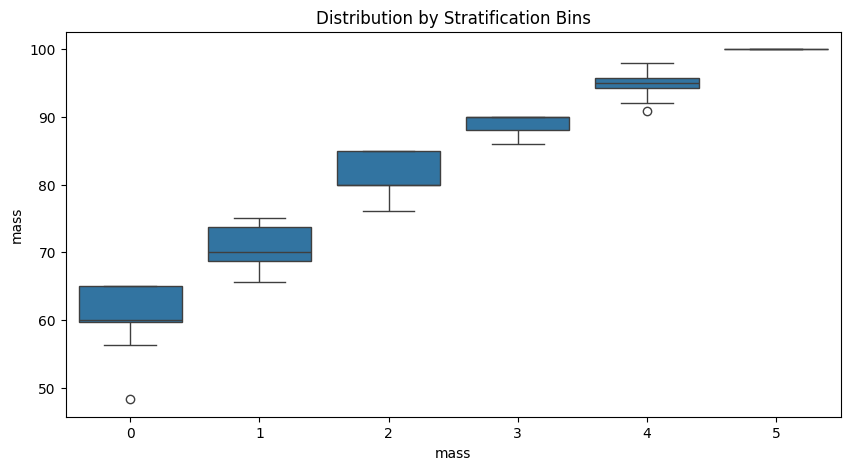

Original y: [100.   95.   90.   85.   80.   75.   70.   65.   60.  100.   98.   96.
  94.   92.   90.   88.   86.   84.   90.   80.   70.   60.   95.   85.
  75.   65.   98.   90.   80.   70.   95.   85.   75.   65.   90.   80.
  70.   60.   95.   85.   75.   65.  100.   71.7  59.4  48.3 100.   87.6
  71.8  62.9 100.   82.6  72.4  66.  100.   76.1  67.3  56.3 100.   90.9
  77.2  65.6 100.   89.4  76.2  66.4]
Binned y:   [5 4 3 2 2 1 1 0 0 5 4 4 4 4 3 3 3 2 3 2 1 0 4 2 1 0 4 3 2 1 4 2 1 0 3 2 1
 0 4 2 1 0 5 1 0 0 5 3 1 0 5 2 1 1 5 2 1 0 5 4 2 1 5 3 2 1]
mass
0    11
1    15
2    13
3     9
4    10
5     8
Name: count, dtype: int64

Distribution after ADASYN (training data only):
mass
0     9
1    12
2    10
3     7
4     8
5    11
Name: count, dtype: int64
Training model with Randomized Grid Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

Best parameters: {'regressor__random_state': 42, 'regressor__n_estimators': 500, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.33, 'regressor__max_depth': None}

Calibrating with Isotonic Regression (out_of_bounds=clip)...

Base Model (train) results:
Metric         Value          
MAE            9.1249
MedAE          4.2361
R²             0.6374
RMSE           13.9028

Base Model (test) results:
Metric         Value          
MAE            2.1142
MedAE          0.8322
R²             0.9075
RMSE           3.5443

Base Model (val) results:
Metric         Value          
MAE            8.6877
MedAE          9.0445
R²             -0.2096
RMSE           10.3936

Calibrated Model (IsotonicRegression_clip) (train) results:
Metric         Value          
MAE            3.7623
MedAE          1.8571
R²             0.9215
RMSE           6.4684

Calibrated Model (IsotonicRegression_clip) (test) results:
Metric         Value          
MAE       

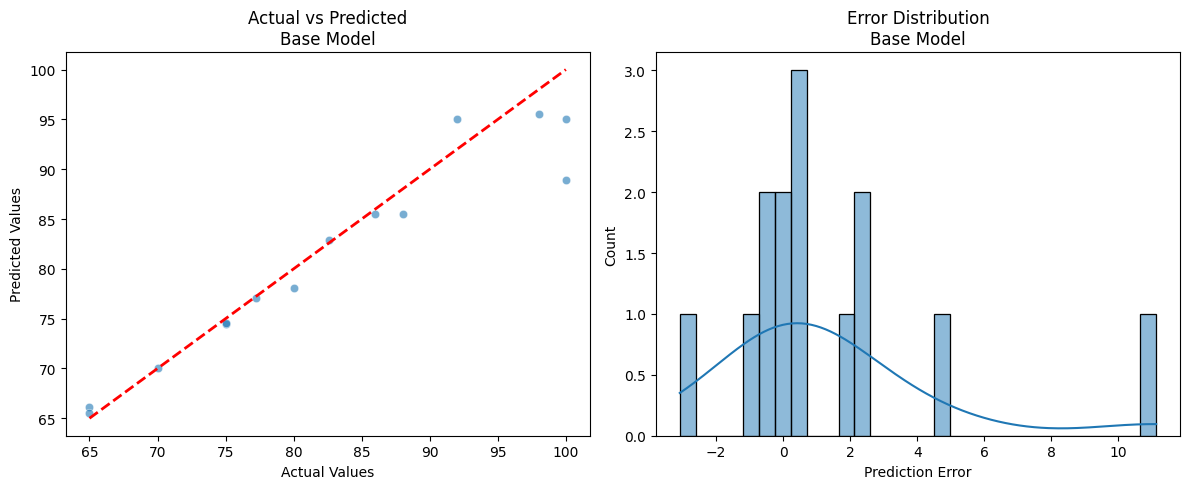

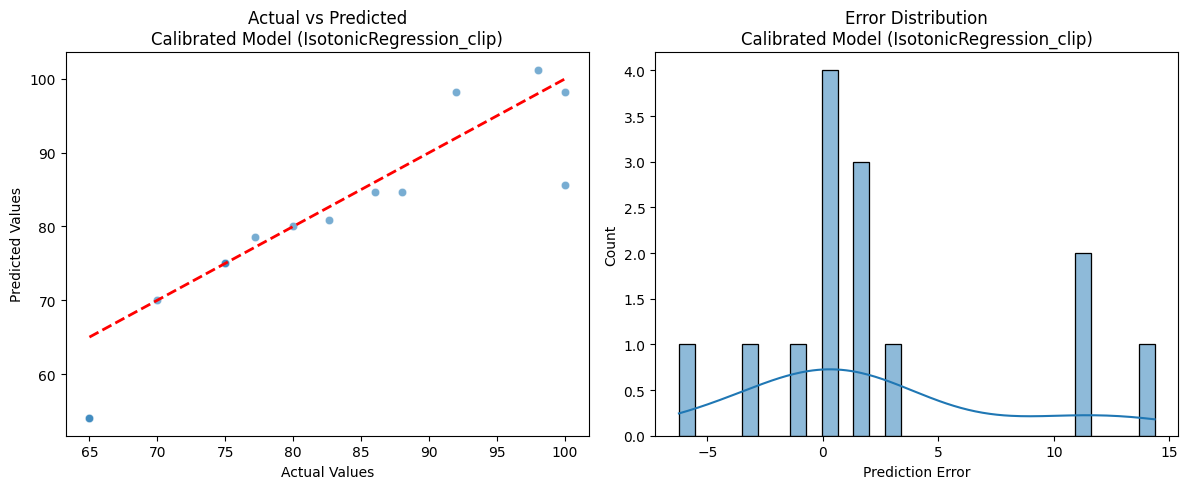

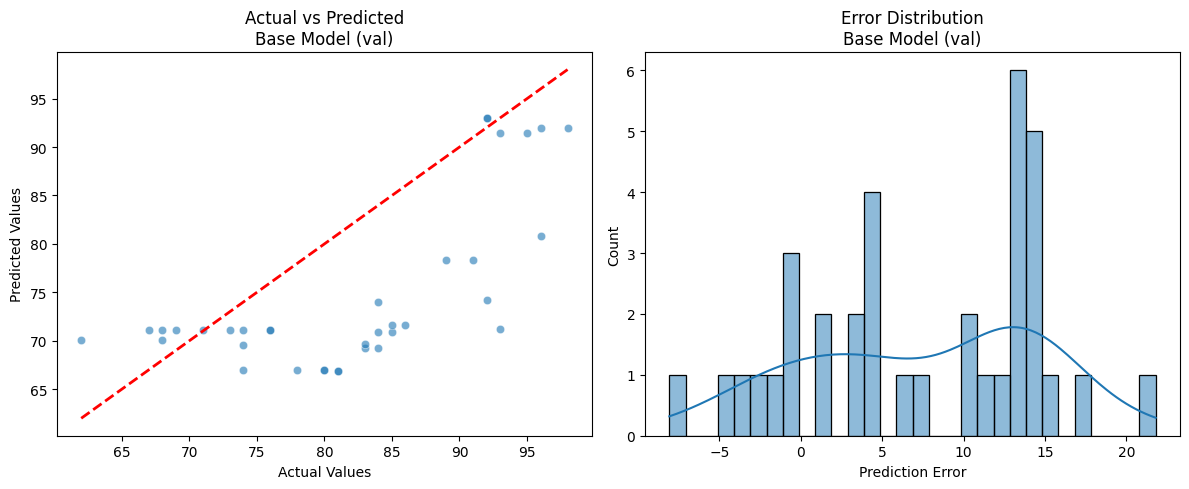

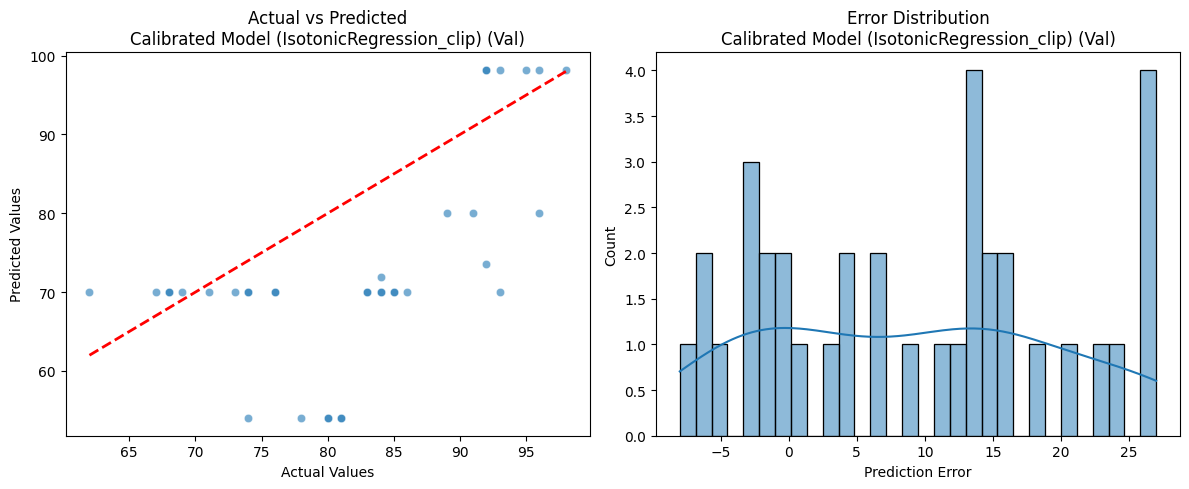

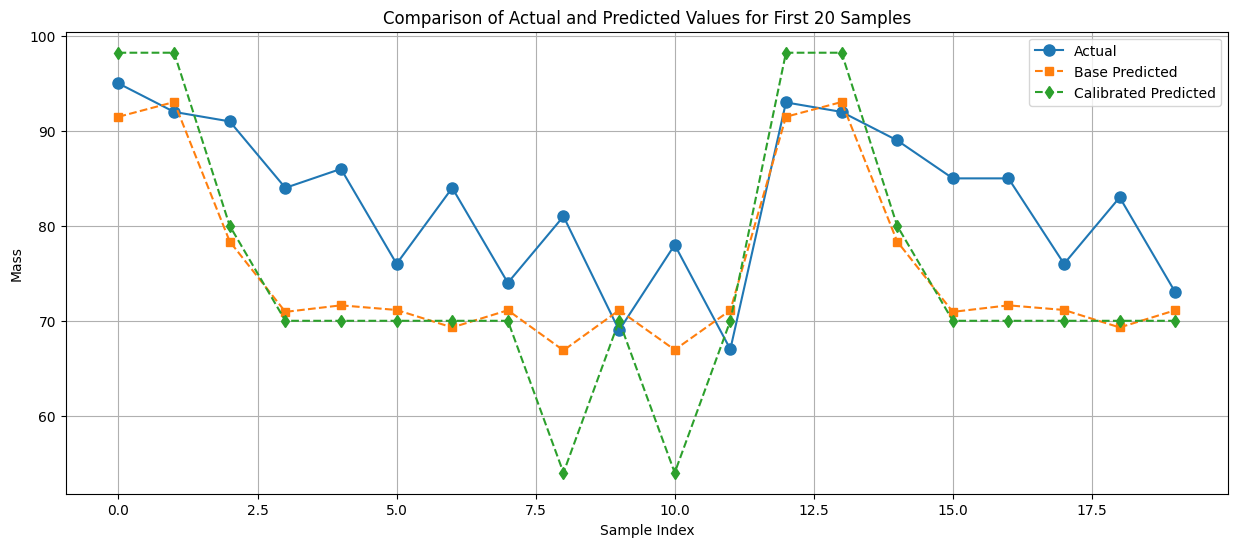


Training Set (top-10 largest errors):
    True_Value  Predicted  Absolute_Error
31        70.0  44.666667       25.333333
6         32.0  54.000000       22.000000
9         70.0  85.642857       15.642857
40        32.0  44.666667       12.666667
41        32.0  44.666667       12.666667
23        87.5  98.233333       10.733333
5         94.5  85.642857        8.857143
33       104.5  98.233333        6.266667
52       104.5  98.233333        6.266667
29       104.5  98.233333        6.266667

Average error in top: 12.669999999999998

Test Set (top-10 largest errors):
    True_Value   Predicted  Absolute_Error
0        100.0   75.000000       14.357143
13        92.0   54.000000        6.233333
9        100.0   80.866667        1.766667
1          NaN  101.250000             NaN
2          NaN   80.000000             NaN
3          NaN   54.000000             NaN
4          NaN   78.600000             NaN
5          NaN   98.233333             NaN
6          NaN   85.642857         

In [ ]:
#лес
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (mean_absolute_error, r2_score,
                           median_absolute_error, mean_squared_error)
from sklearn.preprocessing import RobustScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Load and preprocess data
train_df = pd.read_excel('/content/big_train_no_duples.xlsx')
train_df = train_df[(train_df['article'] == 1) | (train_df['article'] == 2) | (train_df['article'] == 14)]

X = train_df.drop(columns=['mass'])
y = train_df['mass']

# Binning for stratification
bins = [-1, 65, 75, 85, 90, 99, 110]
y_binned = pd.cut(y, bins=bins, labels=False, duplicates='drop')

plt.figure(figsize=(10, 5))
sns.boxplot(x=y_binned, y=y)
plt.title('Distribution by Stratification Bins')
plt.show()

print("Original y:", y.values)
print("Binned y:  ", y_binned.values)
bin_counts = y_binned.value_counts().sort_index()
print(bin_counts)

# Preprocessing pipeline
numerical_cols = ['day', 'ph', '% second component']  # Moved '% second component' to categorical due to string values
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality',
                    'porosity', 'in vivo', 'enzymatic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X, y)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_binned)

# Train-test split before ADASYN
X_train, X_test, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X_preprocessed, y, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned,
)

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)
X_train_resampled, y_train_resampled_binned = adasyn.fit_resample(X_train, y_train_binned)

# Convert binned labels to continuous values
bin_centers = []
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]
    median_val = (lower + upper) / 2
    bin_centers.append(median_val)

y_train_resampled = np.array([bin_centers[int(cls)] for cls in y_train_resampled_binned])

print("\nDistribution after ADASYN (training data only):")
print(pd.Series(y_train_resampled_binned).value_counts().sort_index())

X_train_preprocessed = X_train_resampled
X_test_preprocessed = X_test

# Parameters for RandomForestRegressor
param_dist = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_depth': [None, 10, 20, 30, 40],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2', 0.33],
    'regressor__random_state': [42]
}

base_model = Pipeline([
    ('regressor', RandomForestRegressor())
])

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Training model with Randomized Grid Search...")
random_search.fit(X_preprocessed, y, regressor__sample_weight=sample_weights)

print("Best parameters:", random_search.best_params_)

base_model = random_search.best_estimator_

# Base predictions for calibration
base_pred_train = base_model.predict(X_train_preprocessed)
base_pred_test = base_model.predict(X_test_preprocessed)

base_pred_all = np.concatenate([base_pred_train, base_pred_test])
y_all = np.concatenate([y_train_resampled, y_test])

# Define calibrators
calibrators = {
    'IsotonicRegression_clip': {
        'calibrator': IsotonicRegression(out_of_bounds='clip'),
        'description': 'Isotonic Regression (out_of_bounds=clip)'
    },
    'IsotonicRegression_raise': {
        'calibrator': IsotonicRegression(out_of_bounds='raise'),
        'description': 'Isotonic Regression (out_of_bounds=raise)'
    },
    'PlattScaling_Linear': {
        'calibrator': LinearRegression(),
        'description': 'Platt Scaling (Linear Regression)'
    },
    'PlattScaling_Ridge_alpha1': {
        'calibrator': Ridge(alpha=1.0),
        'description': 'Platt Scaling (Ridge, alpha=1.0)'
    },
    'PlattScaling_Ridge_alpha10': {
        'calibrator': Ridge(alpha=10.0),
        'description': 'Platt Scaling (Ridge, alpha=10.0)'
    },
    'BetaCalibration_Poly1': {
        'calibrator': make_pipeline(PolynomialFeatures(degree=1), LinearRegression()),
        'description': 'Beta Calibration (Polynomial degree=1)'
    },
    'BetaCalibration_Poly2': {
        'calibrator': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
        'description': 'Beta Calibration (Polynomial degree=2)'
    },
    'BetaCalibration_Poly3': {
        'calibrator': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
        'description': 'Beta Calibration (Polynomial degree=3)'
    }
}

calibration_results = {}

# Load validation data
val_df = pd.read_excel('/content/test_no_psb.xlsx')

X_val = val_df.drop(columns=['mass'])
y_val = val_df['mass']
X_val_preprocessed = preprocessor.transform(X_val)

# Base predictions for all sets
y_pred_train_base = base_model.predict(X_train_preprocessed)
y_pred_test_base = base_model.predict(X_test_preprocessed)
y_pred_val_base = base_model.predict(X_val_preprocessed)

# Experiments with calibrators
best_calibrator_name = None
best_mae_val = float('inf')

for calib_name, config in calibrators.items():
    print(f"\nCalibrating with {config['description']}...")

    # Fit calibrator
    calibrator = config['calibrator']
    try:
        calibrator.fit(base_pred_all.reshape(-1, 1), y_all)
    except ValueError as e:
        print(f"Error during calibration {calib_name}: {e}")
        continue

    # Predictions with calibration
    def calibrated_predict(X):
        base_pred = base_model.predict(X)
        try:
            return calibrator.predict(base_pred.reshape(-1, 1))
        except ValueError as e:
            print(f"Error during prediction with {calib_name}: {e}")
            return base_pred

    y_pred_train_cal = calibrated_predict(X_train_preprocessed)
    y_pred_test_cal = calibrated_predict(X_test_preprocessed)
    y_pred_val_cal = calibrated_predict(X_val_preprocessed)

    # Metrics
    def print_metrics(y_true, y_pred, model_name):
        mae = mean_absolute_error(y_true, y_pred)
        medae = median_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        rmse_val = rmse(y_true, y_pred)
        print(f"\n{model_name} results:")
        print(f"{'Metric':<15}{'Value':<15}")
        print(f"{'MAE':<15}{mae:.4f}")
        print(f"{'MedAE':<15}{medae:.4f}")
        print(f"{'R²':<15}{r2:.4f}")
        print(f"{'RMSE':<15}{rmse_val:.4f}")
        return mae

    # Base model metrics (once)
    if calib_name == list(calibrators.keys())[0]:
        print_metrics(y_train_resampled, y_pred_train_base, "Base Model (train)")
        print_metrics(y_test, y_pred_test_base, "Base Model (test)")
        print_metrics(y_val, y_pred_val_base, "Base Model (val)")

    # Calibrated model metrics
    mae_train = print_metrics(y_train_resampled, y_pred_train_cal, f"Calibrated Model ({calib_name}) (train)")
    mae_test = print_metrics(y_test, y_pred_test_cal, f"Calibrated Model ({calib_name}) (test)")
    mae_val = print_metrics(y_val, y_pred_val_cal, f"Calibrated Model ({calib_name}) (val)")

    calibration_results[calib_name] = {
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mae_val': mae_val,
        'calibrator': calibrator,
        'y_pred_train_cal': y_pred_train_cal,
        'y_pred_test_cal': y_pred_test_cal,
        'y_pred_val_cal': y_pred_val_cal
    }

    # Update best calibrator
    if mae_val < best_mae_val:
        best_mae_val = mae_val
        best_calibrator_name = calib_name

print(f"\nBest Calibrator: {calibrators[best_calibrator_name]['description']} with Validation MAE: {best_mae_val:.4f}")

# Use best calibrator for visualization and error analysis
best_calibrator_info = calibration_results[best_calibrator_name]
calibrator = best_calibrator_info['calibrator']
y_pred_train_cal = best_calibrator_info['y_pred_train_cal']
y_pred_test_cal = best_calibrator_info['y_pred_test_cal']
y_pred_val_cal = best_calibrator_info['y_pred_val_cal']

def calibrated_predict(X):
    base_pred = base_model.predict(X)
    return calibrator.predict(base_pred.reshape(-1, 1))

# Visualization
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted\n{title}')

    plt.subplot(1, 2, 2)
    errors = y_true - y_pred
    sns.histplot(errors, kde=True, bins=30)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title(f'Error Distribution\n{title}')

    plt.tight_layout()
    plt.show()

plot_results(y_test, y_pred_test_base, "Base Model")
plot_results(y_test, y_pred_test_cal, f"Calibrated Model ({best_calibrator_name})")
plot_results(y_val, y_pred_val_base, "Base Model (val)")
plot_results(y_val, y_pred_val_cal, f"Calibrated Model ({best_calibrator_name}) (Val)")

# Compare first 20 samples
plt.figure(figsize=(15, 6))
sample_indices = range(min(20, len(y_val)))
plt.plot(sample_indices, y_val[sample_indices], 'o-', label='Actual', markersize=8)
plt.plot(sample_indices, y_pred_val_base[sample_indices], 's--', label='Base Predicted', markersize=6)
plt.plot(sample_indices, y_pred_val_cal[sample_indices], 'd--', label='Calibrated Predicted', markersize=6)
plt.xlabel('Sample Index')
plt.ylabel('Mass')
plt.title('Comparison of Actual and Predicted Values for First 20 Samples')
plt.legend()
plt.grid(True)
plt.show()

# Error analysis
train_errors = abs(y_train_resampled - y_pred_train_cal)
test_errors = abs(y_test - y_pred_test_cal)
val_errors = abs(y_val - y_pred_val_cal)

# Feature names after preprocessing
num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = list(num_features) + list(cat_features)

# Map resampled indices to original data
def get_original_indices(X_resampled, X_original):
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_original)
    _, indices = nbrs.kneighbors(X_resampled)
    return indices.flatten()

# Get original indices for train data
original_indices = get_original_indices(X_train_resampled, X_preprocessed)

# Create DataFrame with errors for train
train_df_with_errors = pd.DataFrame(X_train_resampled, columns=all_feature_names)
train_df_with_errors['True_Value'] = y_train_resampled
train_df_with_errors['Predicted'] = y_pred_train_cal
train_df_with_errors['Absolute_Error'] = train_errors

# Add original categorical features
for col in categorical_cols:
    train_df_with_errors[col] = train_df.iloc[original_indices][col].values

# DataFrames for test and validation
test_df_with_errors = pd.DataFrame(X_test, columns=all_feature_names)
test_df_with_errors['True_Value'] = y_test
test_df_with_errors['Predicted'] = y_pred_test_cal
test_df_with_errors['Absolute_Error'] = test_errors

val_df_with_errors = pd.DataFrame(X_val_preprocessed, columns=all_feature_names)
val_df_with_errors['True_Value'] = y_val
val_df_with_errors['Predicted'] = y_pred_val_cal
val_df_with_errors['Absolute_Error'] = val_errors

# Print top errors
def print_top_errors(error_df, title, n=10):
    top_errors = error_df.sort_values('Absolute_Error', ascending=False).head(n)
    print(f"\n{title} (top-{n} largest errors):")
    cols_to_show = ['True_Value', 'Predicted', 'Absolute_Error']
    print(top_errors[cols_to_show])
    print("\nAverage error in top:", top_errors['Absolute_Error'].mean())

print_top_errors(train_df_with_errors, "Training Set")
print_top_errors(test_df_with_errors, "Test Set")
print_top_errors(val_df_with_errors, "Validation Set")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

# Load your dataset (replace with your file path)
data = pd.read_excel('/content/big_train_no_duples.xlsx')

# Preprocess 'ph' column (convert '7,4' to 7.4)
data['ph'] = data['ph'].astype(str).str.replace(',', '.').astype(float)
data = data[(data['article'] == 2) | (data['article'] == 14)]

# Define categorical and numerical columns
categorical_cols = ['environment', 'form', 'environment_type', 'form_type',
                    'dimensionality', 'type of pha']
numerical_cols = ['% second component', 'ph', 'day']

# Define features and target
X = data.drop('mass', axis=1)
y = data['mass']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__subsample': [0.7, 0.9, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best Cross-Validation RMSE:", best_rmse)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)

# Evaluate on test set
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Test Set MAE:", mae)
print("Test Set RMSE:", rmse)
print("Test Set R² Score:", r2)

# Load and preprocess validation data
test_data = pd.read_excel('/content/test_no_psb.xlsx')
test_data['ph'] = test_data['ph'].astype(str).str.replace(',', '.').astype(float)
X_test_final = test_data.drop(['mass', 'article'], axis=1, errors='ignore')
y_test_final = test_data['mass']

# Make predictions on validation set
y_pred_final = best_model.predict(X_test_final)

# Evaluate on validation set
mae = mean_absolute_error(y_test_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
r2 = r2_score(y_test_final, y_pred_final)
print("Validation Set MAE:", mae)
print("Validation Set RMSE:", rmse)
print("Validation Set R² Score:", r2)

# Plot 1: Scatter Plot of Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_final, y_pred_final, color='blue', alpha=0.5)
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=2)
plt.xlabel('Actual Mass')
plt.ylabel('Predicted Mass')
plt.title('Predicted vs Actual Mass (Validation Set)')
plt.tight_layout()
plt.savefig('predicted_vs_actual.png')
plt.close()

# Plot 2: Error Distribution
errors = y_test_final - y_pred_final
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='purple', alpha=0.7)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Validation Set)')
plt.tight_layout()
plt.savefig('error_distribution.png')
plt.close()

print(f"Mean Prediction Error: {np.mean(errors):.4f}")
print(f"Standard Deviation of Errors: {np.std(errors):.4f}")

Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__subsample': 0.9}
Best Cross-Validation RMSE: 3.3790741786954404
Test Set MAE: 4.727581634521486
Test Set RMSE: 6.441012259397108
Test Set R² Score: 0.8737929613243904
Validation Set MAE: 7.024709701538086
Validation Set RMSE: 8.775478217415614
Validation Set R² Score: 0.13768309354782104
Mean Prediction Error: 6.0933
Standard Deviation of Errors: 6.3151


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import KBinsDiscretizer

# Load dataset
data = pd.read_excel('/content/big_train_no_duples.xlsx')

# Preprocess 'ph' column
data['ph'] = data['ph'].astype(str).str.replace(',', '.').astype(float)
data = data[(data['article'] == 2) | (data['article'] == 14)]

# Define columns
categorical_cols = ['environment', 'form', 'environment_type', 'form_type', 'dimensionality', 'type of pha']
numerical_cols = ['% second component', 'ph', 'day']

# Define features and target
X = data.drop('mass', axis=1)
y = data['mass']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Discretize y_train
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
y_train_binned = discretizer.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Fit and transform training data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(k_neighbors=3, random_state=42)
X_train_smote, y_train_binned_smote = smote.fit_resample(X_train_preprocessed, y_train_binned)

# Map binned labels back to continuous values
bin_edges = discretizer.bin_edges_[0]
y_train_smote = np.zeros_like(y_train_binned_smote, dtype=float)
for i in range(len(bin_edges)-1):
    mask = (y_train_binned_smote == i)
    y_train_smote[mask] = (bin_edges[i] + bin_edges[i+1]) / 2

# Create pipeline with regressor only
pipeline = Pipeline([
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Define parameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    return_train_score=True
)

# Fit with SMOTE-applied data
grid_search.fit(X_train_smote, y_train_smote)

# Print results
print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best Cross-Validation RMSE:", best_rmse)

# Cross-validation metrics
scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_mean_squared_error',
    'r2': 'r2'
}
cv_results = cross_validate(
    estimator=grid_search.best_estimator_,
    X=X_train_smote,
    y=y_train_smote,
    cv=5,
    scoring=scoring
)

print("\nCross-Validation Metrics (per fold):")
for i in range(5):
    mae = -cv_results['test_mae'][i]
    rmse = np.sqrt(-cv_results['test_rmse'][i])
    r2 = cv_results['test_r2'][i]
    print(f"Fold {i+1}: MAE = {mae:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")

print("\nAverage Cross-Validation Metrics:")
print(f"MAE: {-np.mean(cv_results['test_mae']):.4f} (±{np.std(cv_results['test_mae']):.4f})")
print(f"RMSE: {np.sqrt(-np.mean(cv_results['test_rmse'])):.4f} (±{np.std(np.sqrt(-cv_results['test_rmse'])):.4f})")
print(f"R²: {np.mean(cv_results['test_r2']):.4f} (±{np.std(cv_results['test_r2']):.4f})")

# Predictions on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

# Evaluate test set
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\nTest Set Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Load and preprocess validation data
test_data = pd.read_excel('/content/test_no_psb.xlsx')
test_data['ph'] = test_data['ph'].astype(str).str.replace(',', '.').astype(float)
X_test_final = test_data.drop(['mass', 'article'], axis=1, errors='ignore')
y_test_final = test_data['mass']

# Preprocess validation data
X_test_final_preprocessed = preprocessor.transform(X_test_final)

# Predictions on validation set
y_pred_final = best_model.predict(X_test_final_preprocessed)

# Evaluate validation set
mae = mean_absolute_error(y_test_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
r2 = r2_score(y_test_final, y_pred_final)
print("\nValidation Set Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot 1: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_final, y_pred_final, color='blue', alpha=0.5)
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=2)
plt.xlabel('Actual Mass')
plt.ylabel('Predicted Mass')
plt.title('Predicted vs Actual Mass (Validation Set)')
plt.tight_layout()
plt.savefig('predicted_vs_actual.png')
plt.close()

# Plot 2: Error Distribution
errors = y_test_final - y_pred_final
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='purple', alpha=0.7)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Validation Set)')
plt.tight_layout()
plt.savefig('error_distribution.png')
plt.close()

print(f"\nMean Prediction Error: {np.mean(errors):.4f}")
print(f"Standard Deviation of Errors: {np.std(errors):.4f}")

Best Parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}
Best Cross-Validation RMSE: 8.755862499550087

Cross-Validation Metrics (per fold):
Fold 1: MAE = 7.2085, RMSE = 7.4106, R² = 0.5900
Fold 2: MAE = 8.7877, RMSE = 9.3960, R² = 0.3634
Fold 3: MAE = 7.3403, RMSE = 7.7590, R² = 0.6089
Fold 4: MAE = 8.1145, RMSE = 8.7009, R² = 0.3080
Fold 5: MAE = 8.3432, RMSE = 10.2086, R² = -0.3027

Average Cross-Validation Metrics:
MAE: 7.9588 (±0.6008)
RMSE: 8.7559 (±1.0303)
R²: 0.3135 (±0.3304)

Test Set Metrics:
MAE: 11.7893
RMSE: 12.6497
R²: 0.5132

Validation Set Metrics:
MAE: 6.3849
RMSE: 7.7088
R²: 0.3346

Mean Prediction Error: 5.4345
Standard Deviation of Errors: 5.4673


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor

# Load your dataset (replace with your file path)
data = pd.read_excel('/content/train_first_mass_types.xlsx')

# Preprocess 'ph' column (convert '7,4' to 7.4)
data['ph'] = data['ph'].astype(str).str.replace(',', '.').astype(float)

# Define categorical and numerical columns
categorical_cols = ['environment_type', 'form_type',
                    'dimensionality', 'type of pha']
numerical_cols = ['% second component', 'ph', 'day']

# Define features and target
X = data.drop('mass', axis=1)
y = data['mass']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best Cross-Validation RMSE:", best_rmse)

# Cross-validation metrics for the best model
scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_mean_squared_error',
    'r2': 'r2'
}
cv_results = cross_validate(
    estimator=grid_search.best_estimator_,
    X=X_train,
    y=y_train,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# Print cross-validation metrics for each fold
print("\nCross-Validation Metrics (per fold):")
for i in range(5):
    mae = -cv_results['test_mae'][i]
    rmse = np.sqrt(-cv_results['test_rmse'][i])
    r2 = cv_results['test_r2'][i]
    print(f"Fold {i+1}: MAE = {mae:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")

# Print average cross-validation metrics
print("\nAverage Cross-Validation Metrics:")
print(f"MAE: {-np.mean(cv_results['test_mae']):.4f} (±{np.std(cv_results['test_mae']):.4f})")
print(f"RMSE: {np.sqrt(-np.mean(cv_results['test_rmse'])):.4f} (±{np.std(np.sqrt(-cv_results['test_rmse'])):.4f})")
print(f"R²: {np.mean(cv_results['test_r2']):.4f} (±{np.std(cv_results['test_r2']):.4f})")

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)

# Evaluate on test set
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\nTest Set Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Load and preprocess validation data
test_data = pd.read_excel('/content/test_no_psb.xlsx')
test_data['ph'] = test_data['ph'].astype(str).str.replace(',', '.').astype(float)
X_test_final = test_data.drop(['mass', 'article'], axis=1, errors='ignore')
y_test_final = test_data['mass']

# Make predictions on validation set
y_pred_final = best_model.predict(X_test_final)

# Evaluate on validation set
mae = mean_absolute_error(y_test_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
r2 = r2_score(y_test_final, y_pred_final)
print("\nValidation Set Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot 1: Scatter Plot of Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_final, y_pred_final, color='blue', alpha=0.5)
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=2)
plt.xlabel('Actual Mass')
plt.ylabel('Predicted Mass')
plt.title('Predicted vs Actual Mass (Validation Set)')
plt.tight_layout()
plt.savefig('predicted_vs_actual.png')
plt.close()

# Plot 2: Error Distribution
errors = y_test_final - y_pred_final
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='purple', alpha=0.7)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Validation Set)')
plt.tight_layout()
plt.savefig('error_distribution.png')
plt.close()

print(f"\nMean Prediction Error: {np.mean(errors):.4f}")
print(f"Standard Deviation of Errors: {np.std(errors):.4f}")

Best Parameters: {'regressor__learning_rate': 0.3, 'regressor__max_depth': 5, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}
Best Cross-Validation RMSE: 3.142405653213054

Cross-Validation Metrics (per fold):
Fold 1: MAE = 10.6237, RMSE = 17.1031, R² = 0.6293
Fold 2: MAE = 10.9770, RMSE = 17.2014, R² = 0.3554
Fold 3: MAE = 11.5145, RMSE = 23.3655, R² = 0.3909
Fold 4: MAE = 12.1434, RMSE = 22.5989, R² = 0.3940
Fold 5: MAE = 4.1149, RMSE = 5.6968, R² = 0.9449

Average Cross-Validation Metrics:
MAE: 9.8747 (±2.9253)
RMSE: 18.3167 (±6.3165)
R²: 0.5429 (±0.2234)

Test Set Metrics:
MAE: 10.0625
RMSE: 18.3707
R²: 0.7000

Validation Set Metrics:
MAE: 44.3732
RMSE: 45.7306
R²: -22.4174

Mean Prediction Error: 44.3732
Standard Deviation of Errors: 11.0593


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, Normalizer
from sklearn.impute import SimpleImputer

# Load your dataset (replace 'data.csv' with your file path)
data = pd.read_excel('/content/big_train_no_duples.xlsx')

# Preprocess 'ph' column (convert '7,4' to 7.4)
data['ph'] = data['ph'].astype(str).str.replace(',', '.').astype(float)
data = data[(data['article'] == 2) | (data['article'] == 14)]

# Define categorical and numerical columns
categorical_cols = ['environment_type', 'form_type',
                    'dimensionality', 'type of pha']
numerical_cols = ['% second component', 'ph', 'day']

X = data.drop('mass', axis=1)
y = data['mass']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean'))
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the regressor
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [1, 2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best Cross-Validation RMSE:", best_rmse)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Test Set MAE:", mae)
print("Test Set RMSE:", rmse)
print("Test Set R² Score:", r2)

test_data = pd.read_excel('/content/test_no_psb.xlsx')

# Preprocess 'ph' column (convert '7,4' to 7.4)
test_data['ph'] = test_data['ph'].astype(str).str.replace(',', '.').astype(float)
X_test_final = test_data.drop(['mass', 'article'], axis=1, errors='ignore')

X = preprocessor.transform(X_test_final)

y = test_data['mass']


# Make predictions
y_pred = best_model.predict(X)

# Calculate metrics
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print("Val Set MAE:", mae)
print("Val Set RMSE:", rmse)
print("Val Set R² Score:", r2)

# Plot 1: Scatter Plot of Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, color='blue', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Mass')
plt.ylabel('Predicted Mass')
plt.title('Predicted vs Actual Mass')
plt.tight_layout()
plt.show()
# Plot 2: Error Distribution
errors = y - y_pred
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='purple', alpha=0.7)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

print(f"Mean Prediction Error: {np.mean(errors):.4f}")
print(f"Standard Deviation of Errors: {np.std(errors):.4f}")

In [ ]:
importances = best_model.named_steps['regressor'].feature_importances_
feature_names = numerical_cols + list(
    best_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_cols)
)

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. day (0.8945839359416716)
2. form_scaffold (0.026681511374075102)
3. environment_type_bloodstream (0.02120176718996439)
4. environment_bloodstream (0.012420824174690337)
5. environment_phosphate buffer (0.005989982958833891)
6. environment_type_phosphate buffer (0.005938101840195157)
7. environment_subcutaneous (0.005564932479116215)
8. % second component (0.004171476694208918)
9. environment_type_tissue implantation (0.003513924220001699)
10. environment_type_simulated gastric juice (0.002611302477583649)
11. ph (0.0024058087582237526)
12. environment_synthetic gastric juice (0.0022916676130989347)
13. environment_intramuscular (0.002097081636608401)


<ipython-input-30-4572a9d10177>:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T,


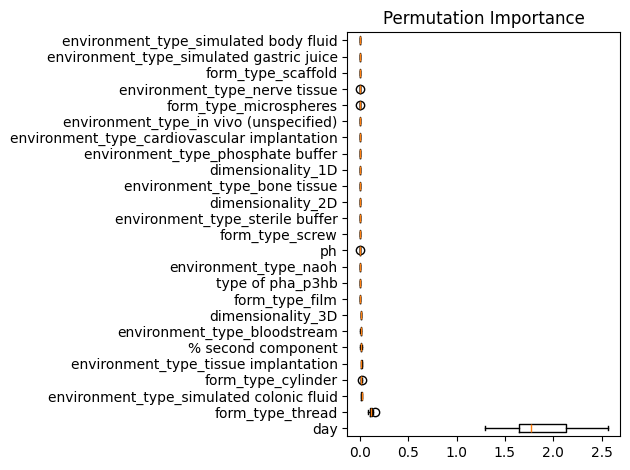

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

rf = GradientBoostingRegressor(learning_rate=0.1,max_depth=5,
                               min_samples_split=10, n_estimators=300, random_state=42)
data = pd.read_excel('/content/big_train_no_duples.xlsx')

data['ph'] = data['ph'].astype(str).str.replace(',', '.').astype(float)
data = data[(data['article'] == 2) | (data['article'] == 14)]

# Define categorical and numerical columns
categorical_cols = ['environment_type', 'form_type','environment', 'form',
                    'dimensionality', 'type of pha']
numerical_cols = ['% second component', 'ph', 'day']

X = data.drop('mass', axis=1)
y = data['mass']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean'))
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


rf.fit(X_train, y_train)

result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]

plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()

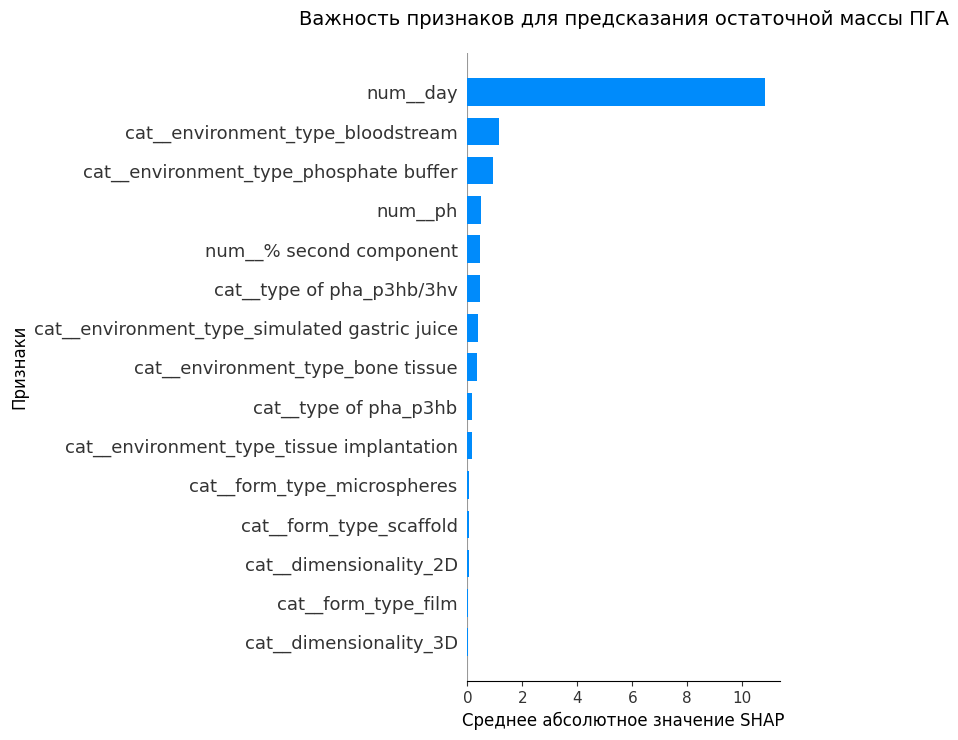

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import shap

# Устанавливаем шрифт Times New Roman для соответствия требованиям ИТМО
plt.rcParams['font.family'] = 'Times New Roman'

# Чтение данных
data = pd.read_excel('/content/big_train_no_duples.xlsx')

# Предобработка столбца 'ph' (замена запятой на точку)
data['ph'] = data['ph'].astype(str).str.replace(',', '.').astype(float)

# Фильтрация данных по статьям (article == 2 или 14)
data = data[(data['article'] == 2) | (data['article'] == 14)]

# Определяем числовые и категориальные столбцы
numerical_cols = ['% second component', 'ph', 'day']
categorical_cols = ['environment_type', 'form_type', 'dimensionality', 'type of pha']
target_col = 'mass'

# Создаём препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean'))
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Подготовка данных
X = data[numerical_cols + categorical_cols]
y = data[target_col]

# Преобработка признаков
X_preprocessed = preprocessor.fit_transform(X)

# Получаем имена признаков после предобработки
feature_names = preprocessor.get_feature_names_out()

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Обучаем модель GradientBoostingRegressor
rf = GradientBoostingRegressor(learning_rate=0.1, max_depth=5,
                              min_samples_split=10, n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Создаём SHAP-объяснитель
explainer = shap.TreeExplainer(rf)

# Вычисляем SHAP-значения
shap_values = explainer.shap_values(X_preprocessed)

# Создаём summary plot с корректными именами признаков
plt.figure(figsize=(10, 8))  # Размер графика
shap.summary_plot(shap_values, X_preprocessed, plot_type="bar", feature_names=feature_names, show=False)

# Настраиваем заголовок и подписи
plt.title('Важность признаков для предсказания остаточной массы ПГА', fontsize=14, pad=20)
plt.xlabel('Среднее абсолютное значение SHAP', fontsize=12)
plt.ylabel('Признаки', fontsize=12)

# Увеличиваем плотность компоновки
plt.tight_layout()

# Сохраняем график в высоком разрешении для ВКР
plt.savefig('shap_importance.png', dpi=300, bbox_inches='tight')

# Показываем график
plt.show()

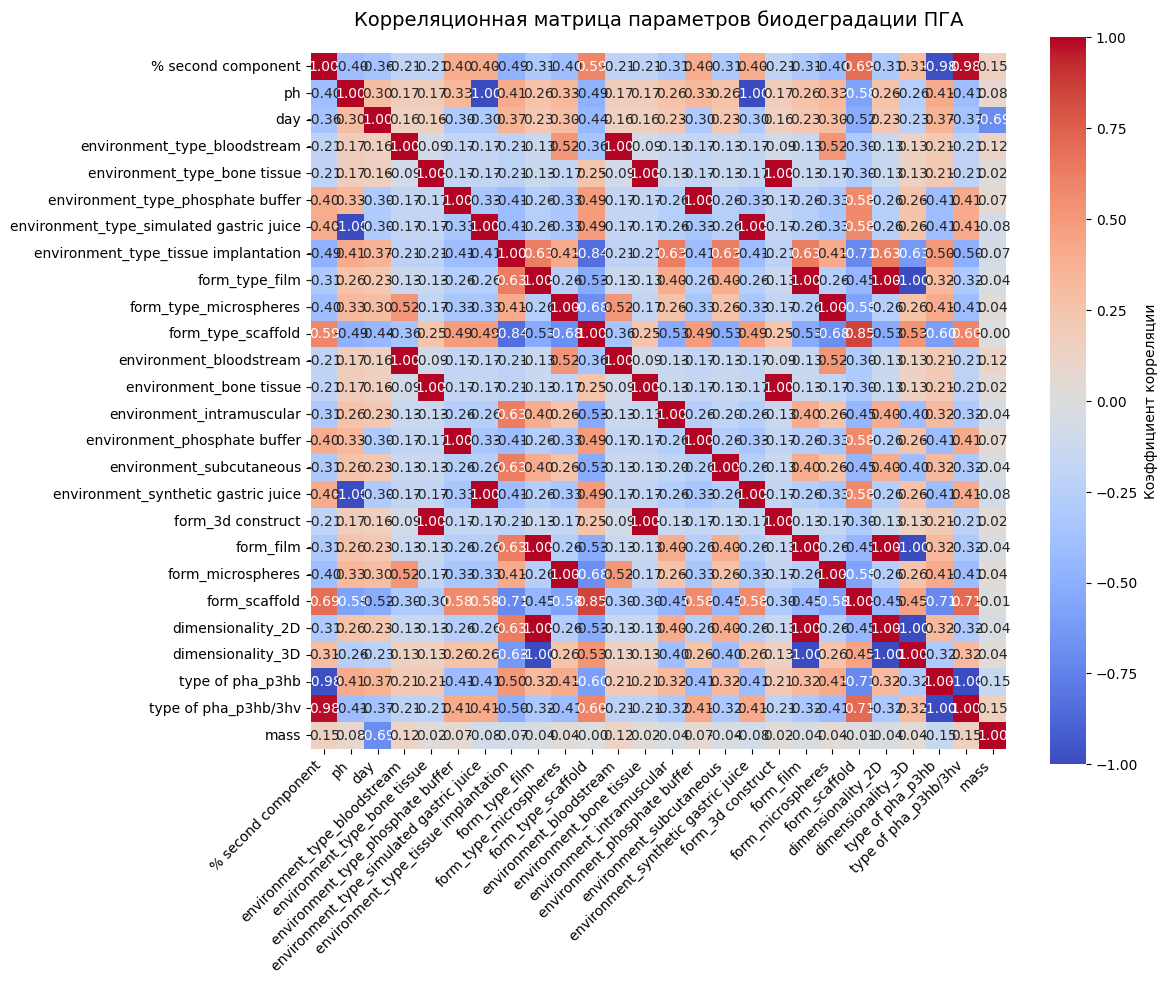

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Чтение данных
data = pd.read_excel('/content/big_train_no_duples.xlsx')

data['ph'] = data['ph'].astype(str).str.replace(',', '.').astype(float)
data = data[(data['article'] == 2) | (data['article'] == 14)]

# Определяем числовые и категориальные столбцы
numerical_cols = ['% second component', 'ph', 'day']
categorical_cols = ['environment_type', 'form_type','environment', 'form', 'dimensionality', 'type of pha']
target_col = ['mass']  # Целевая переменная

# Создаём препроцессор для числовых и категориальных столбцов
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean'))
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Преобразуем признаки (X) и объединяем с целевой переменной (y)
X = data[numerical_cols + categorical_cols]
y = data[target_col]

# Применяем препроцессор к признакам
X_preprocessed = preprocessor.fit_transform(X)

# Получаем имена столбцов после one-hot encoding
feature_names = (numerical_cols +
                 list(preprocessor.named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(categorical_cols)))

# Создаём DataFrame с предобработанными признаками и целевой переменной
df_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names)
df_preprocessed['mass'] = y.values

# Вычисляем корреляционную матрицу (метод Пирсона)
corr_matrix = df_preprocessed.corr(method='pearson')

# Создаём тепловую карту
plt.figure(figsize=(12, 10))  # Увеличенный размер для множества признаков
sns.heatmap(
    corr_matrix,
    annot=True,  # Показывать значения корреляции
    cmap='coolwarm',  # Цветовая схема
    vmin=-1, vmax=1,  # Диапазон значений корреляции
    center=0,  # Центр цветовой шкалы
    fmt='.2f',  # Формат чисел (2 знака после запятой)
    annot_kws={'size': 10},  # Уменьшенный размер шрифта для читаемости
    square=True,  # Квадратные ячейки
    cbar_kws={'label': 'Коэффициент корреляции'}  # Подпись цветовой шкалы
)

# Настраиваем заголовок и подписи
plt.title('Корреляционная матрица параметров биодеградации ПГА', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Поворот подписей для читаемости
plt.yticks(fontsize=10)  # Размер подписей по оси Y

# Увеличиваем плотность компоновки
plt.tight_layout()

# Сохраняем изображение в высоком разрешении для ВКР
plt.savefig('correlation_matrix_with_categorical.png', dpi=300, bbox_inches='tight')

# Показываем график
plt.show()

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation RMSE: 3.3854428809241486
Test Set MAE: 2.2174999999999994
Test Set RMSE: 2.857349077379242
Test Set R² Score: 0.9356417785441556
Val Set MAE: 17.39770833333333
Val Set RMSE: 22.87437535577019
Val Set R² Score: -0.25594915678680286


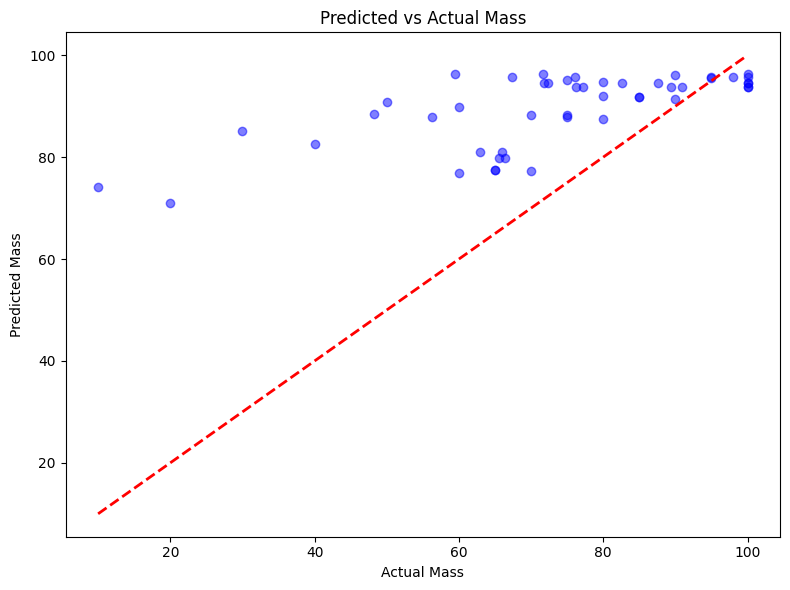

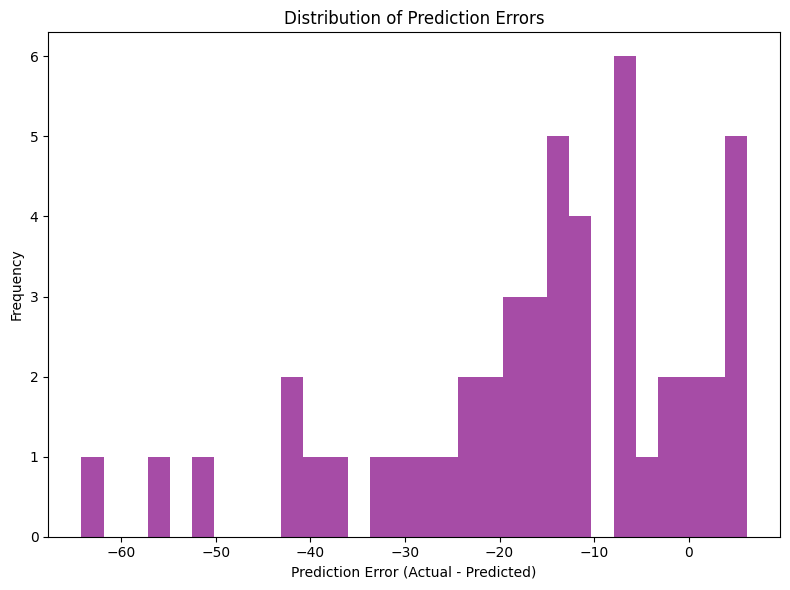

Mean Prediction Error: -16.0023
Standard Deviation of Errors: 16.3451


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.compose import ColumnTransformer
import joblib

# Load your dataset (replace 'data.csv' with your file path)
data = pd.read_excel('/content/preprocessed_test (2) no psb.xlsx')

# Preprocess 'ph' column (convert '7,4' to 7.4)
data['ph'] = data['ph'].astype(str).str.replace(',', '.').astype(float)
#data = data[(data['article'] == 2) | (data['article'] == 14)]

# Define categorical and numerical columns
categorical_cols = ['environment', 'form',
                    'dimensionality', 'type of pha']
numerical_cols = ['% second component', 'ph', 'day']

X = data.drop('mass', axis=1)
y = data['mass']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean'))
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the regressor
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best Cross-Validation RMSE:", best_rmse)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Test Set MAE:", mae)
print("Test Set RMSE:", rmse)
print("Test Set R² Score:", r2)

test_data = pd.read_excel('/content/preprocessed_train1 (7).xlsx')

# Preprocess 'ph' column (convert '7,4' to 7.4)
test_data['ph'] = test_data['ph'].astype(str).str.replace(',', '.').astype(float)
test_data = test_data[(test_data['article'] == 2)|(test_data['article'] == 9)]
X_test_final = test_data.drop(['mass', 'article'], axis=1, errors='ignore')

X = preprocessor.transform(X_test_final)

y = test_data['mass']


# Make predictions
y_pred = best_model.predict(X)

# Calculate metrics
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print("Val Set MAE:", mae)
print("Val Set RMSE:", rmse)
print("Val Set R² Score:", r2)

# Plot 1: Scatter Plot of Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, color='blue', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Mass')
plt.ylabel('Predicted Mass')
plt.title('Predicted vs Actual Mass')
plt.tight_layout()
plt.show()
# Plot 2: Error Distribution
errors = y - y_pred
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='purple', alpha=0.7)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

print(f"Mean Prediction Error: {np.mean(errors):.4f}")
print(f"Standard Deviation of Errors: {np.std(errors):.4f}")

Best Parameters: {'fit_intercept': True, 'positive': False}
Best Cross-Validation RMSE: 8.500204998263584
Test Set MAE: 7.042839726752686
Test Set RMSE: 9.5065619675488
Test Set R² Score: 0.6607382056331463
Final Test Set MAE: 11.6955837281254
Final Test Set RMSE: 14.36575092057645
Final Test Set R² Score: -1.310904191047166


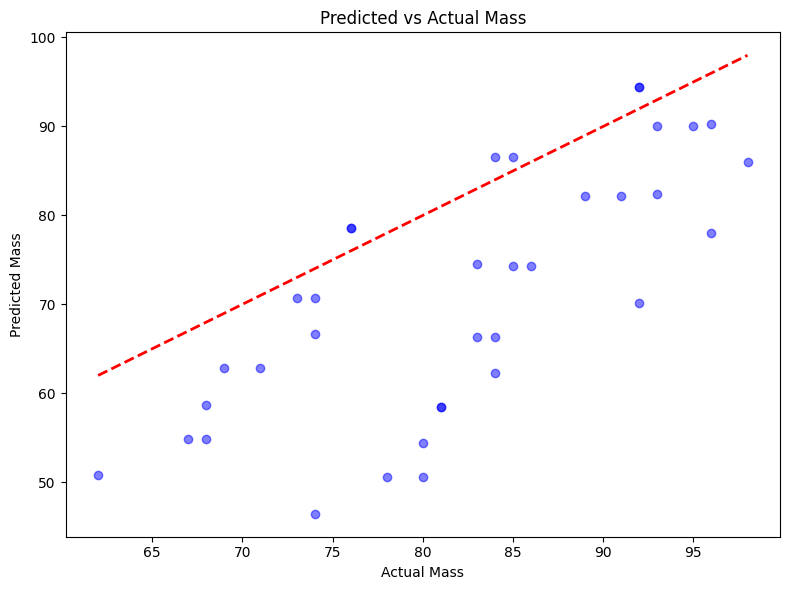

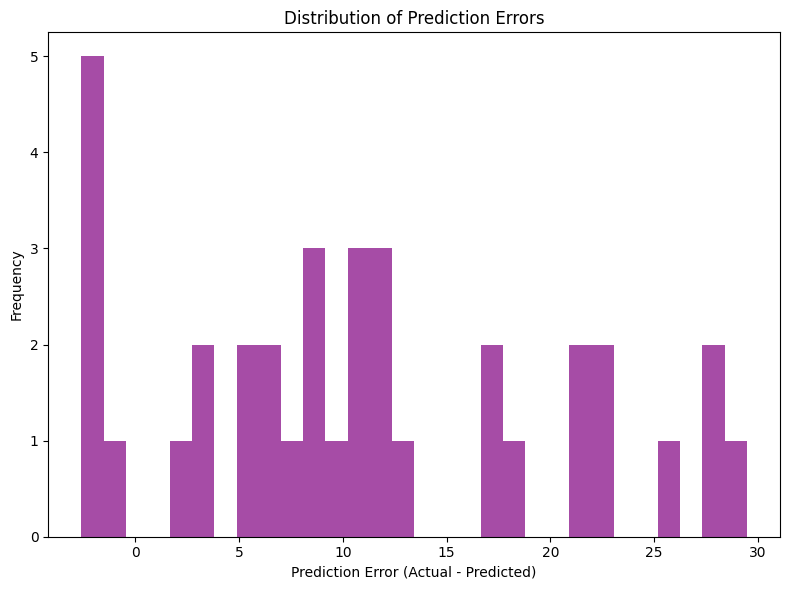

Mean Prediction Error: 10.9136
Standard Deviation of Errors: 9.3417


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_excel('/content/big_train_no_duples.xlsx')

# Preprocess 'ph' column (convert '7,4' to 7.4)
data['ph'] = data['ph'].astype(str).str.replace(',', '.').astype(float)
data = data[(data['article'] == 1) | (data['article'] == 2) | (data['article'] == 14)]

# Define categorical and numerical columns
categorical_cols = ['environment', 'form', 'environment_type', 'form_type',
                    'dimensionality', 'type of pha', 'in vivo', 'porosity', 'enzymatic']
numerical_cols = ['% second component', 'ph', 'day']

# Ensure categorical columns are strings
for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].astype(str)

# Split features and target
X = data.drop(['mass', 'article'], axis=1, errors='ignore')
y = data['mass']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean'))
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the linear regression model
lr = LinearRegression()

# Define the parameter grid for GridSearchCV
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid,
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best Cross-Validation RMSE:", best_rmse)
model = grid_search.best_estimator_


# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Test Set MAE:", mae)
print("Test Set RMSE:", rmse)
print("Test Set R² Score:", r2)

# Load test data
test_data = pd.read_excel('/content/test_no_psb.xlsx')

# Preprocess 'ph' column (convert '7,4' to 7.4)
test_data['ph'] = test_data['ph'].astype(str).str.replace(',', '.').astype(float)

# Prepare test features
X_test_final = test_data.drop(['mass', 'article'], axis=1, errors='ignore')

# Preprocess test data
X_test_preprocessed = preprocessor.transform(X_test_final)

# Check if we have true values for evaluation
if 'mass' in test_data.columns:
    y_test_final = test_data['mass']
    # Make predictions
    y_pred = model.predict(X_test_preprocessed)

    # Calculate metrics
    mae = mean_absolute_error(y_test_final, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_final, y_pred))
    r2 = r2_score(y_test_final, y_pred)
    print("Final Test Set MAE:", mae)
    print("Final Test Set RMSE:", rmse)
    print("Final Test Set R² Score:", r2)

    # Plot 1: Scatter Plot of Predicted vs Actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_final, y_pred, color='blue', alpha=0.5)
    plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=2)
    plt.xlabel('Actual Mass')
    plt.ylabel('Predicted Mass')
    plt.title('Predicted vs Actual Mass')
    plt.tight_layout()
    plt.show()

    # Plot 2: Error Distribution
    errors = y_test_final - y_pred
    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=30, color='purple', alpha=0.7)
    plt.xlabel('Prediction Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.tight_layout()
    plt.show()

    print(f"Mean Prediction Error: {np.mean(errors):.4f}")
    print(f"Standard Deviation of Errors: {np.std(errors):.4f}")
else:
    # Make predictions only
    y_pred = model.predict(X_test_preprocessed)
    print("Predictions completed successfully. No true values provided for evaluation.")
    # Save predictions
    test_data['predicted_mass'] = y_pred
    test_data.to_excel('predictions.xlsx', index=False)